**Main imports**

In [ ]:
!pip install tqdm
!pip install zipfile
!pip install PIL
!pip install IPython

In [17]:
print("Importing...")
import os
import requests
from tqdm import tqdm
import zipfile
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Imports complete.')

Importing...
Imports complete.


**Download dataset**

In [53]:
# URL of the file
url = 'https://data.ncl.ac.uk/ndownloader/articles/24574354/versions/1'

# make directory if it doesn't exist
directory = 'classification-data'
if not os.path.exists(directory):
    os.makedirs(directory)

# where to save the downloaded file
file_path = os.path.join(directory, 'downloaded_file.zip')

# send a GET request to the URL with stream=True for chunked download
response = requests.get(url, stream=True)

# check if the request was successful
if response.status_code == 200:
    # total size in bytes from the header
    total_size = int(response.headers.get('content-length', 0))

    # progress bar
    with open(file_path, 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                progress_bar.update(len(chunk))

    print("File downloaded successfully!")

    # unzipping
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(directory)
        print(f"Files unzipped successfully in the '{directory}' directory!")

    # remove the zip file after extraction
    os.remove(file_path)
    print("Zip file removed after extraction.")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Downloading: 100%|██████████| 629M/629M [00:10<00:00, 63.0MB/s] 


File downloaded successfully!
Files unzipped successfully in the 'classification-data' directory!
Zip file removed after extraction.


**Import dataset**

In [18]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = np.load(train_x_path)
train_y = np.load(train_y_path)
valid_x = np.load(valid_x_path)
valid_y = np.load(valid_y_path)
test_x = np.load(test_x_path)
test_y = np.load(test_y_path)
print("Data loaded successfully.")

# convert NumPy arrays to PyTorch tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()
valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000


Training Progress:  70%|███████   | 7000/10000 [01:54<00:44, 67.97it/s]

**View some of the test dataset**

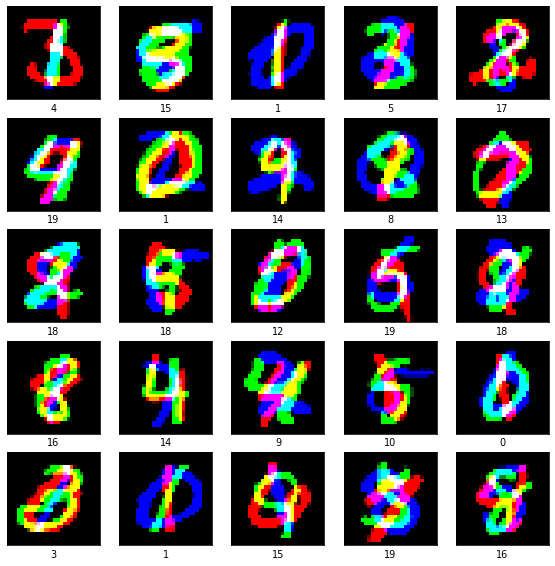

In [3]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Define a simple model**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Effiency Enhancers**

In [20]:
# Swish Activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [21]:
# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.excite = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        weights = self.squeeze(x).view(batch, channels)
        weights = self.excite(weights).view(batch, channels, 1, 1)
        return x * weights

In [22]:
# Inverted Residual Block
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=4, stride=1, use_se=True):
        super(InvertedResidual, self).__init__()
        self.use_residual = (stride == 1 and in_channels == out_channels)
        hidden_dim = in_channels * expansion

        self.block = nn.Sequential(
            # Expansion
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish(),
            # Depthwise Convolution
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish(),
            # Squeeze-and-Excitation
            SEBlock(hidden_dim) if use_se else nn.Identity(),
            # Projection
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

**Full CNN**

In [23]:
# {'lr': 0.005039249213460068, 'weight_decay': 1.1710476673989e-05, 'dropout_rate': 0.272670753800897} -> 84.95%
class CustomCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(CustomCNN, self).__init__()
        self.num_classes = num_classes
        self.dropout = nn.Dropout(p=0.272670753800897)
        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.swish = Swish()

        # Inverted Residual Blocks
        self.block1 = InvertedResidual(16, 32, expansion=4, stride=2)  # Downsampling
        self.block2 = InvertedResidual(32, 32, expansion=4, stride=1)
        self.block3 = InvertedResidual(32, 64, expansion=8, stride=2, use_se=True)  # Downsampling

        # Global Average Pooling and Fully Connected Layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, self.num_classes, bias=True)

    def forward(self, x):
        x = self.swish(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

**Main Training and Testing Functions**

In [26]:
from time import sleep 
# Training loop
def train_model(N, train_loader, valid_loader, max_steps, criterion, optimiser):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    N.to(device)
    epoch = 0
    step = 0
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    valid_loss_arr = np.zeros(0)
    valid_acc_arr = np.zeros(0)
    best_valid_loss = float('inf')
    progress_bar = tqdm(total=max_steps, desc="Training Progress")
    plot_data = []
    epoch_data = []
    while step < max_steps:
        N.train()
        epoch_train_acc = []
        epoch_valid_acc = []
        
        for i in range(1000):
            x,t = next(train_iterator)
            x,t = x.to(device), t.to(device)

            # Forward pass
            p = N(x)
            pred = p.argmax(dim=1, keepdim=True)
            loss = criterion(p, t)

            # Backward pass and optimization
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            step += 1
            
            train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
            train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())
            epoch_train_acc.append(pred.data.eq(t.view_as(pred)).float().mean().item())

            # Stop training if max_steps reached
            if step >= max_steps:
                break
        epoch += 1
        progress_bar.update(step//epoch)
        # Validate the model - reduce chance of overfitting
        valid_loss, valid_acc, _ = evaluate_model(N, valid_loader, criterion)
#         valid_acc = valid_acc[-1]
        valid_loss_arr = np.append(valid_loss_arr, valid_loss)
        valid_acc_arr = np.append(valid_acc_arr, valid_acc)
        epoch_valid_acc.append(np.array(valid_acc).mean())

        print(f"Step {step}/{max_steps} - Validation Loss: {valid_loss:.4f}, Validation Accuracy: {np.array(valid_acc_arr).mean():.2f}")
    
        epoch_data.append([step, np.array(epoch_train_acc).mean(), np.array(epoch_train_acc).std(), np.array(epoch_valid_acc).mean(), np.array(epoch_valid_acc).std()])
        reward_list = []
        plt.plot([x[0] for x in epoch_data], [x[1] for x in epoch_data], '-', color='tab:grey', label="Train accuracy")
        plt.fill_between([x[0] for x in epoch_data], [x[1]-x[2] for x in epoch_data], [x[1]+x[2] for x in epoch_data], alpha=0.2, color='tab:grey')
        plt.plot([x[0] for x in epoch_data], [x[3] for x in epoch_data], '-', color='tab:purple', label="Validation accuracy")
        plt.fill_between([x[0] for x in epoch_data], [x[3]-x[4] for x in epoch_data], [x[3]+x[4] for x in epoch_data], alpha=0.2, color='tab:purple')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.show()
#         disp.clear_output(wait=True)
        plot_data.append([step, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(valid_acc_arr).mean(), np.array(valid_acc_arr).std()])
        reward_list = []
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Validation accuracy")
        plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.show()
    progress_bar.close()
    print("Training complete!")
    return train_loss_arr, train_acc_arr, valid_loss_arr, valid_acc_arr

# Evaluation function
def evaluate_model(N, data_loader, criterion):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    N.eval()
    total_loss = 0
    correct = 0
    total = 0
    test_acc_arr = np.zeros(0)
    test_loss_arr = np.zeros(0)
    with torch.no_grad():
        for x, t in data_loader:
            x, t = x.to(device), t.to(device)
            p = N(x)

            # Calculate loss
            loss = criterion(p, t)
            total_loss += loss.item()
            test_loss_arr = np.append(test_loss_arr, loss.cpu().data)
            
            pred = p.argmax(dim=1, keepdim=True)
            test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())
    avg_loss = total_loss / len(data_loader)
#     accuracy = (correct / total) * 100
    return avg_loss, test_acc_arr, test_loss_arr

**RUN TEST AND TRAIN LOOPS**

In [ ]:
# Initialise model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = CustomCNN(num_classes=20).to(device)

# print the number of model parameters
print(f'Number of model parameters is: {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser - parameters values present are identified from hyperparamter tuning later in file 
optimiser = torch.optim.Adam(N.parameters(), lr=0.005039249213460068, weight_decay = 1.1710476673989e-05)


criterion = nn.CrossEntropyLoss()
train_loss_arr, train_acc_arr, valid_loss_arr, valid_acc_arr = train_model(N, train_loader, valid_loader, 10000, criterion, optimiser)
print('* Train loss: {:.3f}±{:.3f}'.format(train_loss_arr.mean(), train_loss_arr.std()),'Train Accuracy:{:.3f}±{:.3f}'.format(train_acc_arr.mean(),train_acc_arr.std()))
print('* Valid loss: {:.3f}±{:.3f}'.format(valid_loss_arr.mean(), valid_loss_arr.std()),'Valid Accuracy:{:.3f}±{:.3f}'.format(valid_acc_arr.mean(),valid_acc_arr.std()))
test_loss, test_accuracy, test_loss_arr = evaluate_model(N, test_loader, criterion)
print('* Test Accuracy: {:.3f}'.format(test_accuracy.mean()))
print('* Test Loss: {:.3f}'.format(test_loss))

**HYPERPARAMETER TUNING**

In [ ]:
!pip install optuna

In [10]:
import optuna
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [11]:
def tune(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = CustomCNN(num_classes=20).to(device)
    lr = trial.suggest_loguniform('lr', 4.75e-3, 8e-3)  # Learning rate
    decay = trial.suggest_loguniform('weight_decay', 1e-5, 2.5e-5)  # Weight decay
    dr = trial.suggest_uniform('dropout_rate', 0.25, 0.35)  # Dropout rate
    N.dropout = nn.Dropout(p=dr)
    # print the number of model parameters
    print(f'Number of model parameters is: {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

    # initialise the optimiser
    optimiser = torch.optim.Adam(N.parameters(), lr=lr, weight_decay = decay)


    criterion = nn.CrossEntropyLoss()
    epoch = 0
    train_model(N, train_loader, valid_loader, 10000, criterion, optimiser)
    test_loss, test_accuracy = evaluate_model(N, test_loader, criterion)
    print('* Test Accuracy: {:.3f}'.format(test_accuracy))
    print('* Test Loss: {:.3f}'.format(test_loss))
    return test_accuracy
study = optuna.create_study(direction='minimize')  # Minimize the loss
study.optimize(tune, n_trials=50)  # Try 50 different combinations

# Best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2025-01-09 18:32:37,689] A new study created in memory with name: no-name-8ae6ef62-e5d3-4aff-94cd-f8a06e485a9e
/tmp/ipykernel_3433467/1937930578.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 4.75e-3, 8e-3)  # Learning rate
/tmp/ipykernel_3433467/1937930578.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  decay = trial.suggest_loguniform('weight_decay', 1e-5, 2.5e-5)  # Weight decay
/tmp/ipykernel_3433467/1937930578.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dr = trial.sugge

Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:55, 80.74it/s]

Step 703/10000 - Validation Loss: 2.1582, Validation Accuracy: 25.61%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:50, 77.87it/s]

Step 1406/10000 - Validation Loss: 1.9025, Validation Accuracy: 35.01%


Training Progress:  21%|██        | 2109/10000 [00:27<01:42, 77.15it/s]

Step 2109/10000 - Validation Loss: 1.6237, Validation Accuracy: 45.07%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.80it/s]

Step 2812/10000 - Validation Loss: 1.5079, Validation Accuracy: 52.96%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.62it/s]

Step 3515/10000 - Validation Loss: 1.1294, Validation Accuracy: 63.66%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.53it/s]

Step 4218/10000 - Validation Loss: 1.2674, Validation Accuracy: 59.18%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.52it/s]

Step 4921/10000 - Validation Loss: 1.0073, Validation Accuracy: 68.98%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.44it/s]

Step 5624/10000 - Validation Loss: 0.8019, Validation Accuracy: 75.74%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.38it/s]

Step 6327/10000 - Validation Loss: 0.8947, Validation Accuracy: 73.35%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.33it/s]

Step 7030/10000 - Validation Loss: 0.9350, Validation Accuracy: 71.73%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.38it/s]

Step 7733/10000 - Validation Loss: 0.7700, Validation Accuracy: 77.11%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.35it/s]

Step 8436/10000 - Validation Loss: 0.7914, Validation Accuracy: 76.97%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.36it/s]

Step 9139/10000 - Validation Loss: 0.7402, Validation Accuracy: 78.86%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.38it/s]

Step 9842/10000 - Validation Loss: 0.9031, Validation Accuracy: 73.79%


Training Progress: 10545it [02:12, 79.79it/s]                          

Step 10000/10000 - Validation Loss: 0.7878, Validation Accuracy: 77.42%
Training complete!



[W 2025-01-09 18:34:50,584] Trial 0 failed with parameters: {'lr': 0.006983531763953468, 'weight_decay': 1.5671087564418698e-05, 'dropout_rate': 0.33457173257536665} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:34:50,584] Trial 0 failed with value None.


* Test Accuracy: 78.280
* Test Loss: 0.741
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.69it/s]

Step 703/10000 - Validation Loss: 2.3160, Validation Accuracy: 25.53%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.72it/s]

Step 1406/10000 - Validation Loss: 1.8607, Validation Accuracy: 35.68%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.07it/s]

Step 2109/10000 - Validation Loss: 1.8494, Validation Accuracy: 39.27%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.37it/s]

Step 2812/10000 - Validation Loss: 1.6379, Validation Accuracy: 47.02%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.04it/s]

Step 3515/10000 - Validation Loss: 1.2393, Validation Accuracy: 59.29%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.86it/s]

Step 4218/10000 - Validation Loss: 1.1193, Validation Accuracy: 64.12%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.61it/s]

Step 4921/10000 - Validation Loss: 0.9684, Validation Accuracy: 69.63%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.46it/s]

Step 5624/10000 - Validation Loss: 0.9719, Validation Accuracy: 69.57%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.46it/s]

Step 6327/10000 - Validation Loss: 0.9331, Validation Accuracy: 70.75%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.35it/s]

Step 7030/10000 - Validation Loss: 0.9999, Validation Accuracy: 69.89%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.35it/s]

Step 7733/10000 - Validation Loss: 1.0739, Validation Accuracy: 68.05%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.38it/s]

Step 8436/10000 - Validation Loss: 0.8431, Validation Accuracy: 74.69%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.29it/s]

Step 9139/10000 - Validation Loss: 0.7543, Validation Accuracy: 77.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.20it/s]

Step 9842/10000 - Validation Loss: 0.8158, Validation Accuracy: 75.91%


Training Progress: 10545it [02:11, 79.99it/s]                          

Step 10000/10000 - Validation Loss: 0.7020, Validation Accuracy: 78.91%
Training complete!



[W 2025-01-09 18:37:03,042] Trial 1 failed with parameters: {'lr': 0.006498931470309494, 'weight_decay': 1.979178345754725e-05, 'dropout_rate': 0.26028243904270676} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:37:03,043] Trial 1 failed with value None.


* Test Accuracy: 80.410
* Test Loss: 0.650
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.83it/s]

Step 703/10000 - Validation Loss: 2.1594, Validation Accuracy: 25.33%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.60it/s]

Step 1406/10000 - Validation Loss: 1.8249, Validation Accuracy: 38.32%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.11it/s]

Step 2109/10000 - Validation Loss: 1.5537, Validation Accuracy: 48.27%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.49it/s]

Step 2812/10000 - Validation Loss: 1.4460, Validation Accuracy: 53.61%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.11it/s]

Step 3515/10000 - Validation Loss: 1.2204, Validation Accuracy: 61.98%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.90it/s]

Step 4218/10000 - Validation Loss: 0.9590, Validation Accuracy: 69.92%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.75it/s]

Step 4921/10000 - Validation Loss: 0.8615, Validation Accuracy: 73.39%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.64it/s]

Step 5624/10000 - Validation Loss: 0.9218, Validation Accuracy: 71.97%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:47, 76.57it/s]

Step 6327/10000 - Validation Loss: 0.9651, Validation Accuracy: 71.49%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.55it/s]

Step 7030/10000 - Validation Loss: 0.8716, Validation Accuracy: 74.79%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.52it/s]

Step 7733/10000 - Validation Loss: 0.6762, Validation Accuracy: 79.58%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.51it/s]

Step 8436/10000 - Validation Loss: 0.7590, Validation Accuracy: 77.80%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.52it/s]

Step 9139/10000 - Validation Loss: 0.6469, Validation Accuracy: 80.81%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.49it/s]

Step 9842/10000 - Validation Loss: 0.6669, Validation Accuracy: 80.70%


Training Progress: 10545it [02:11, 80.19it/s]                          

Step 10000/10000 - Validation Loss: 0.6097, Validation Accuracy: 81.75%
Training complete!



[W 2025-01-09 18:39:15,176] Trial 2 failed with parameters: {'lr': 0.005293772177702103, 'weight_decay': 1.5036336796498115e-05, 'dropout_rate': 0.34168830064326633} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:39:15,177] Trial 2 failed with value None.


* Test Accuracy: 83.030
* Test Loss: 0.583
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.87it/s]

Step 703/10000 - Validation Loss: 2.0675, Validation Accuracy: 27.63%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.76it/s]

Step 1406/10000 - Validation Loss: 1.7636, Validation Accuracy: 39.52%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.23it/s]

Step 2109/10000 - Validation Loss: 1.7535, Validation Accuracy: 40.45%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.52it/s]

Step 2812/10000 - Validation Loss: 1.3528, Validation Accuracy: 56.67%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.18it/s]

Step 3515/10000 - Validation Loss: 1.1482, Validation Accuracy: 63.40%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.96it/s]

Step 4218/10000 - Validation Loss: 1.1371, Validation Accuracy: 64.12%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.81it/s]

Step 4921/10000 - Validation Loss: 1.0113, Validation Accuracy: 69.35%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.64it/s]

Step 5624/10000 - Validation Loss: 0.8567, Validation Accuracy: 74.12%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.50it/s]

Step 6327/10000 - Validation Loss: 0.8060, Validation Accuracy: 75.56%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.45it/s]

Step 7030/10000 - Validation Loss: 0.7464, Validation Accuracy: 77.79%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.37it/s]

Step 7733/10000 - Validation Loss: 0.8317, Validation Accuracy: 75.40%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.27it/s]

Step 8436/10000 - Validation Loss: 0.7364, Validation Accuracy: 78.51%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.30it/s]

Step 9139/10000 - Validation Loss: 0.6695, Validation Accuracy: 79.94%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.31it/s]

Step 9842/10000 - Validation Loss: 0.6417, Validation Accuracy: 80.86%


Training Progress: 10545it [02:11, 80.11it/s]                          

Step 10000/10000 - Validation Loss: 0.6735, Validation Accuracy: 80.05%
Training complete!



[W 2025-01-09 18:41:27,431] Trial 3 failed with parameters: {'lr': 0.005382156105700865, 'weight_decay': 1.0884799240264341e-05, 'dropout_rate': 0.2964968019142407} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:41:27,432] Trial 3 failed with value None.


* Test Accuracy: 82.720
* Test Loss: 0.592
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.61it/s]

Step 703/10000 - Validation Loss: 2.1137, Validation Accuracy: 24.67%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.40it/s]

Step 1406/10000 - Validation Loss: 1.9379, Validation Accuracy: 35.49%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.01it/s]

Step 2109/10000 - Validation Loss: 1.6780, Validation Accuracy: 44.20%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.37it/s]

Step 2812/10000 - Validation Loss: 1.4061, Validation Accuracy: 55.02%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.05it/s]

Step 3515/10000 - Validation Loss: 1.2229, Validation Accuracy: 60.89%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.86it/s]

Step 4218/10000 - Validation Loss: 1.0172, Validation Accuracy: 67.72%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.76it/s]

Step 4921/10000 - Validation Loss: 1.0940, Validation Accuracy: 66.09%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.72it/s]

Step 5624/10000 - Validation Loss: 0.9387, Validation Accuracy: 71.41%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:47, 76.67it/s]

Step 6327/10000 - Validation Loss: 0.8601, Validation Accuracy: 73.70%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.62it/s]

Step 7030/10000 - Validation Loss: 0.8087, Validation Accuracy: 75.25%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.58it/s]

Step 7733/10000 - Validation Loss: 0.8008, Validation Accuracy: 76.16%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.53it/s]

Step 8436/10000 - Validation Loss: 0.7387, Validation Accuracy: 77.85%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.45it/s]

Step 9139/10000 - Validation Loss: 0.8196, Validation Accuracy: 75.08%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.45it/s]

Step 9842/10000 - Validation Loss: 0.8220, Validation Accuracy: 75.71%


Training Progress: 10545it [02:11, 80.17it/s]                          

Step 10000/10000 - Validation Loss: 0.7576, Validation Accuracy: 77.93%
Training complete!



[W 2025-01-09 18:43:39,584] Trial 4 failed with parameters: {'lr': 0.007647284798211158, 'weight_decay': 2.037132067746601e-05, 'dropout_rate': 0.34923175254140426} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:43:39,585] Trial 4 failed with value None.


* Test Accuracy: 78.550
* Test Loss: 0.713
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 85.05it/s]

Step 703/10000 - Validation Loss: 2.5672, Validation Accuracy: 20.03%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.77it/s]

Step 1406/10000 - Validation Loss: 1.7820, Validation Accuracy: 38.11%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.18it/s]

Step 2109/10000 - Validation Loss: 1.5827, Validation Accuracy: 47.31%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.50it/s]

Step 2812/10000 - Validation Loss: 1.5980, Validation Accuracy: 46.47%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.12it/s]

Step 3515/10000 - Validation Loss: 1.2632, Validation Accuracy: 58.09%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.81it/s]

Step 4218/10000 - Validation Loss: 1.1238, Validation Accuracy: 64.01%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.55it/s]

Step 4921/10000 - Validation Loss: 1.1123, Validation Accuracy: 65.22%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.42it/s]

Step 5624/10000 - Validation Loss: 0.9908, Validation Accuracy: 68.95%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.28it/s]

Step 6327/10000 - Validation Loss: 0.8791, Validation Accuracy: 72.62%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.24it/s]

Step 7030/10000 - Validation Loss: 0.8442, Validation Accuracy: 74.58%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.24it/s]

Step 7733/10000 - Validation Loss: 0.8599, Validation Accuracy: 73.69%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.24it/s]

Step 8436/10000 - Validation Loss: 0.7732, Validation Accuracy: 76.51%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.31it/s]

Step 9139/10000 - Validation Loss: 0.7439, Validation Accuracy: 77.41%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.33it/s]

Step 9842/10000 - Validation Loss: 0.8374, Validation Accuracy: 74.51%


Training Progress: 10545it [02:11, 80.02it/s]                          

Step 10000/10000 - Validation Loss: 0.8541, Validation Accuracy: 75.53%
Training complete!



[W 2025-01-09 18:45:51,985] Trial 5 failed with parameters: {'lr': 0.005487705615322266, 'weight_decay': 1.9266722934584787e-05, 'dropout_rate': 0.3281997344030345} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:45:51,985] Trial 5 failed with value None.


* Test Accuracy: 76.130
* Test Loss: 0.826
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 85.16it/s]

Step 703/10000 - Validation Loss: 2.4623, Validation Accuracy: 20.21%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.91it/s]

Step 1406/10000 - Validation Loss: 1.8174, Validation Accuracy: 37.19%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.12it/s]

Step 2109/10000 - Validation Loss: 1.5195, Validation Accuracy: 49.48%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.41it/s]

Step 2812/10000 - Validation Loss: 1.7049, Validation Accuracy: 46.35%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.13it/s]

Step 3515/10000 - Validation Loss: 1.2289, Validation Accuracy: 61.06%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.95it/s]

Step 4218/10000 - Validation Loss: 1.0498, Validation Accuracy: 67.50%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.71it/s]

Step 4921/10000 - Validation Loss: 0.9178, Validation Accuracy: 71.89%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.58it/s]

Step 5624/10000 - Validation Loss: 0.8604, Validation Accuracy: 73.49%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:47, 76.54it/s]

Step 6327/10000 - Validation Loss: 0.8849, Validation Accuracy: 72.66%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.51it/s]

Step 7030/10000 - Validation Loss: 0.8342, Validation Accuracy: 74.51%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.44it/s]

Step 7733/10000 - Validation Loss: 0.8579, Validation Accuracy: 74.12%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.42it/s]

Step 8436/10000 - Validation Loss: 0.7218, Validation Accuracy: 78.07%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 75.88it/s]

Step 9139/10000 - Validation Loss: 0.6906, Validation Accuracy: 79.39%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.02it/s]

Step 9842/10000 - Validation Loss: 0.6554, Validation Accuracy: 80.80%


Training Progress: 10545it [02:11, 80.02it/s]                          

Step 10000/10000 - Validation Loss: 0.6952, Validation Accuracy: 80.04%
Training complete!



[W 2025-01-09 18:48:04,395] Trial 6 failed with parameters: {'lr': 0.006645220494902954, 'weight_decay': 2.2830807272537165e-05, 'dropout_rate': 0.30763913100150947} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:48:04,396] Trial 6 failed with value None.


* Test Accuracy: 81.050
* Test Loss: 0.654
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.91it/s]

Step 703/10000 - Validation Loss: 2.0933, Validation Accuracy: 25.37%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.71it/s]

Step 1406/10000 - Validation Loss: 1.8839, Validation Accuracy: 36.44%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.15it/s]

Step 2109/10000 - Validation Loss: 1.6293, Validation Accuracy: 46.24%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.42it/s]

Step 2812/10000 - Validation Loss: 1.4514, Validation Accuracy: 52.29%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.93it/s]

Step 3515/10000 - Validation Loss: 1.1571, Validation Accuracy: 62.89%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.70it/s]

Step 4218/10000 - Validation Loss: 1.0722, Validation Accuracy: 66.47%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.59it/s]

Step 4921/10000 - Validation Loss: 1.3429, Validation Accuracy: 61.17%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.54it/s]

Step 5624/10000 - Validation Loss: 0.9672, Validation Accuracy: 70.13%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.38it/s]

Step 6327/10000 - Validation Loss: 0.8449, Validation Accuracy: 74.95%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.35it/s]

Step 7030/10000 - Validation Loss: 0.9061, Validation Accuracy: 73.19%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.39it/s]

Step 7733/10000 - Validation Loss: 0.8305, Validation Accuracy: 75.00%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.36it/s]

Step 8436/10000 - Validation Loss: 0.7755, Validation Accuracy: 77.16%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.19it/s]

Step 9139/10000 - Validation Loss: 0.7550, Validation Accuracy: 77.67%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.17it/s]

Step 9842/10000 - Validation Loss: 0.7034, Validation Accuracy: 79.04%


Training Progress: 10545it [02:11, 79.99it/s]                          

Step 10000/10000 - Validation Loss: 0.7819, Validation Accuracy: 77.05%
Training complete!



[W 2025-01-09 18:50:16,854] Trial 7 failed with parameters: {'lr': 0.0067655932870140665, 'weight_decay': 2.1899094309021738e-05, 'dropout_rate': 0.25633497585205567} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:50:16,855] Trial 7 failed with value None.


* Test Accuracy: 77.980
* Test Loss: 0.751
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.77it/s]

Step 703/10000 - Validation Loss: 2.0573, Validation Accuracy: 26.57%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.42it/s]

Step 1406/10000 - Validation Loss: 1.8769, Validation Accuracy: 34.37%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.00it/s]

Step 2109/10000 - Validation Loss: 1.7250, Validation Accuracy: 40.22%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.30it/s]

Step 2812/10000 - Validation Loss: 1.5094, Validation Accuracy: 48.89%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.01it/s]

Step 3515/10000 - Validation Loss: 1.5101, Validation Accuracy: 51.89%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.84it/s]

Step 4218/10000 - Validation Loss: 1.2657, Validation Accuracy: 60.35%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.65it/s]

Step 4921/10000 - Validation Loss: 0.9003, Validation Accuracy: 72.18%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.56it/s]

Step 5624/10000 - Validation Loss: 0.8882, Validation Accuracy: 72.85%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.46it/s]

Step 6327/10000 - Validation Loss: 0.8187, Validation Accuracy: 75.23%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.34it/s]

Step 7030/10000 - Validation Loss: 0.7640, Validation Accuracy: 76.54%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.37it/s]

Step 7733/10000 - Validation Loss: 0.7613, Validation Accuracy: 77.20%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.35it/s]

Step 8436/10000 - Validation Loss: 0.7122, Validation Accuracy: 78.97%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.20it/s]

Step 9139/10000 - Validation Loss: 0.7315, Validation Accuracy: 78.61%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.29it/s]

Step 9842/10000 - Validation Loss: 0.7344, Validation Accuracy: 78.53%


Training Progress: 10545it [02:11, 80.02it/s]                          

Step 10000/10000 - Validation Loss: 0.6997, Validation Accuracy: 79.41%
Training complete!



[W 2025-01-09 18:52:29,245] Trial 8 failed with parameters: {'lr': 0.0063288635062518205, 'weight_decay': 1.6539785447877086e-05, 'dropout_rate': 0.2728814873104748} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:52:29,246] Trial 8 failed with value None.


* Test Accuracy: 80.400
* Test Loss: 0.653
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 85.06it/s]

Step 703/10000 - Validation Loss: 2.0821, Validation Accuracy: 25.99%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.79it/s]

Step 1406/10000 - Validation Loss: 1.9773, Validation Accuracy: 32.06%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.27it/s]

Step 2109/10000 - Validation Loss: 1.9447, Validation Accuracy: 32.44%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.60it/s]

Step 2812/10000 - Validation Loss: 1.5705, Validation Accuracy: 49.13%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.11it/s]

Step 3515/10000 - Validation Loss: 1.8565, Validation Accuracy: 46.05%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.85it/s]

Step 4218/10000 - Validation Loss: 1.0917, Validation Accuracy: 65.45%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.70it/s]

Step 4921/10000 - Validation Loss: 1.1315, Validation Accuracy: 64.27%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.57it/s]

Step 5624/10000 - Validation Loss: 1.0054, Validation Accuracy: 69.10%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:47, 76.54it/s]

Step 6327/10000 - Validation Loss: 0.8525, Validation Accuracy: 74.45%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.40it/s]

Step 7030/10000 - Validation Loss: 1.0169, Validation Accuracy: 68.69%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.37it/s]

Step 7733/10000 - Validation Loss: 0.8128, Validation Accuracy: 75.60%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.35it/s]

Step 8436/10000 - Validation Loss: 0.8388, Validation Accuracy: 75.66%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.35it/s]

Step 9139/10000 - Validation Loss: 0.8898, Validation Accuracy: 73.47%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.24it/s]

Step 9842/10000 - Validation Loss: 0.7746, Validation Accuracy: 77.04%


Training Progress: 10545it [02:11, 80.06it/s]                          

Step 10000/10000 - Validation Loss: 0.7271, Validation Accuracy: 78.37%
Training complete!



[W 2025-01-09 18:54:41,578] Trial 9 failed with parameters: {'lr': 0.007800912161594115, 'weight_decay': 2.2408609082531094e-05, 'dropout_rate': 0.3157105080531356} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:54:41,579] Trial 9 failed with value None.


* Test Accuracy: 79.730
* Test Loss: 0.680
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.99it/s]

Step 703/10000 - Validation Loss: 2.1852, Validation Accuracy: 24.76%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.75it/s]

Step 1406/10000 - Validation Loss: 2.1600, Validation Accuracy: 30.79%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.15it/s]

Step 2109/10000 - Validation Loss: 1.5032, Validation Accuracy: 49.48%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.31it/s]

Step 2812/10000 - Validation Loss: 1.3196, Validation Accuracy: 58.15%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.93it/s]

Step 3515/10000 - Validation Loss: 1.2587, Validation Accuracy: 61.18%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.63it/s]

Step 4218/10000 - Validation Loss: 1.2329, Validation Accuracy: 61.21%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.53it/s]

Step 4921/10000 - Validation Loss: 0.9225, Validation Accuracy: 71.31%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.48it/s]

Step 5624/10000 - Validation Loss: 0.9145, Validation Accuracy: 71.93%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.50it/s]

Step 6327/10000 - Validation Loss: 0.9008, Validation Accuracy: 72.83%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.49it/s]

Step 7030/10000 - Validation Loss: 0.8422, Validation Accuracy: 75.12%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.40it/s]

Step 7733/10000 - Validation Loss: 1.0334, Validation Accuracy: 70.30%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.26it/s]

Step 8436/10000 - Validation Loss: 0.7858, Validation Accuracy: 76.53%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.22it/s]

Step 9139/10000 - Validation Loss: 0.8700, Validation Accuracy: 75.21%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.29it/s]

Step 9842/10000 - Validation Loss: 0.8991, Validation Accuracy: 73.28%


Training Progress: 10545it [02:11, 80.03it/s]                          

Step 10000/10000 - Validation Loss: 0.8217, Validation Accuracy: 76.74%
Training complete!



[W 2025-01-09 18:56:53,961] Trial 10 failed with parameters: {'lr': 0.007158256819204763, 'weight_decay': 1.2335489938516396e-05, 'dropout_rate': 0.3374746008151221} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:56:53,962] Trial 10 failed with value None.


* Test Accuracy: 77.100
* Test Loss: 0.777
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.90it/s]

Step 703/10000 - Validation Loss: 2.2396, Validation Accuracy: 25.49%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.68it/s]

Step 1406/10000 - Validation Loss: 2.0185, Validation Accuracy: 33.03%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.06it/s]

Step 2109/10000 - Validation Loss: 1.6080, Validation Accuracy: 44.47%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.36it/s]

Step 2812/10000 - Validation Loss: 1.4453, Validation Accuracy: 51.65%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.94it/s]

Step 3515/10000 - Validation Loss: 1.2583, Validation Accuracy: 59.02%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.82it/s]

Step 4218/10000 - Validation Loss: 1.0841, Validation Accuracy: 65.36%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.67it/s]

Step 4921/10000 - Validation Loss: 0.9941, Validation Accuracy: 69.04%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.59it/s]

Step 5624/10000 - Validation Loss: 0.9700, Validation Accuracy: 69.99%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.45it/s]

Step 6327/10000 - Validation Loss: 0.9387, Validation Accuracy: 71.30%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.37it/s]

Step 7030/10000 - Validation Loss: 0.8460, Validation Accuracy: 74.31%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.33it/s]

Step 7733/10000 - Validation Loss: 0.7998, Validation Accuracy: 75.47%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.36it/s]

Step 8436/10000 - Validation Loss: 0.7598, Validation Accuracy: 76.99%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.36it/s]

Step 9139/10000 - Validation Loss: 0.7369, Validation Accuracy: 77.37%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.24it/s]

Step 9842/10000 - Validation Loss: 0.8141, Validation Accuracy: 76.13%


Training Progress: 10545it [02:11, 80.04it/s]                          

Step 10000/10000 - Validation Loss: 0.8079, Validation Accuracy: 76.25%
Training complete!



[W 2025-01-09 18:59:06,326] Trial 11 failed with parameters: {'lr': 0.004760483395204825, 'weight_decay': 1.971478232655536e-05, 'dropout_rate': 0.28822877434122496} because of the following error: The value None could not be cast to float..
[W 2025-01-09 18:59:06,327] Trial 11 failed with value None.


* Test Accuracy: 77.830
* Test Loss: 0.764
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.85it/s]

Step 703/10000 - Validation Loss: 2.4204, Validation Accuracy: 22.04%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.36it/s]

Step 1406/10000 - Validation Loss: 2.2724, Validation Accuracy: 25.11%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.78it/s]

Step 2109/10000 - Validation Loss: 1.5941, Validation Accuracy: 46.91%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.30it/s]

Step 2812/10000 - Validation Loss: 1.4311, Validation Accuracy: 53.37%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.93it/s]

Step 3515/10000 - Validation Loss: 1.3127, Validation Accuracy: 58.32%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.59it/s]

Step 4218/10000 - Validation Loss: 1.0651, Validation Accuracy: 67.07%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.42it/s]

Step 4921/10000 - Validation Loss: 1.1027, Validation Accuracy: 65.99%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.40it/s]

Step 5624/10000 - Validation Loss: 0.9112, Validation Accuracy: 72.07%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.39it/s]

Step 6327/10000 - Validation Loss: 0.8038, Validation Accuracy: 75.70%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.38it/s]

Step 7030/10000 - Validation Loss: 0.8741, Validation Accuracy: 73.81%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.44it/s]

Step 7733/10000 - Validation Loss: 1.0218, Validation Accuracy: 70.33%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.46it/s]

Step 8436/10000 - Validation Loss: 0.9869, Validation Accuracy: 70.83%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.43it/s]

Step 9139/10000 - Validation Loss: 0.7380, Validation Accuracy: 77.97%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.28it/s]

Step 9842/10000 - Validation Loss: 0.7769, Validation Accuracy: 76.82%


Training Progress: 10545it [02:11, 79.97it/s]                          

Step 10000/10000 - Validation Loss: 0.7470, Validation Accuracy: 77.96%
Training complete!



[W 2025-01-09 19:01:18,816] Trial 12 failed with parameters: {'lr': 0.007500616831180523, 'weight_decay': 2.299618419932785e-05, 'dropout_rate': 0.25535640464253806} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:01:18,817] Trial 12 failed with value None.


* Test Accuracy: 79.720
* Test Loss: 0.692
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.31it/s]

Step 703/10000 - Validation Loss: 2.1195, Validation Accuracy: 24.71%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.41it/s]

Step 1406/10000 - Validation Loss: 2.3258, Validation Accuracy: 27.49%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.86it/s]

Step 2109/10000 - Validation Loss: 1.8784, Validation Accuracy: 39.99%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.23it/s]

Step 2812/10000 - Validation Loss: 1.5984, Validation Accuracy: 49.49%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.89it/s]

Step 3515/10000 - Validation Loss: 1.3057, Validation Accuracy: 58.37%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.72it/s]

Step 4218/10000 - Validation Loss: 1.0523, Validation Accuracy: 66.79%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.60it/s]

Step 4921/10000 - Validation Loss: 0.9674, Validation Accuracy: 70.67%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.49it/s]

Step 5624/10000 - Validation Loss: 0.8702, Validation Accuracy: 72.66%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.25it/s]

Step 6327/10000 - Validation Loss: 0.7790, Validation Accuracy: 76.27%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.93it/s]

Step 7030/10000 - Validation Loss: 0.7949, Validation Accuracy: 75.70%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.87it/s]

Step 7733/10000 - Validation Loss: 0.9256, Validation Accuracy: 72.05%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.81it/s]

Step 8436/10000 - Validation Loss: 0.7281, Validation Accuracy: 78.23%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.71it/s]

Step 9139/10000 - Validation Loss: 0.7237, Validation Accuracy: 78.56%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.40it/s]

Step 9842/10000 - Validation Loss: 0.6408, Validation Accuracy: 81.29%


Training Progress: 10545it [02:12, 79.53it/s]                          

Step 10000/10000 - Validation Loss: 0.7127, Validation Accuracy: 78.81%
Training complete!



[W 2025-01-09 19:03:32,043] Trial 13 failed with parameters: {'lr': 0.006897036260565567, 'weight_decay': 1.3261230076616823e-05, 'dropout_rate': 0.32591571122624197} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:03:32,044] Trial 13 failed with value None.


* Test Accuracy: 80.100
* Test Loss: 0.655
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.10it/s]

Step 703/10000 - Validation Loss: 2.1027, Validation Accuracy: 26.07%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:49, 78.77it/s]

Step 1406/10000 - Validation Loss: 1.8739, Validation Accuracy: 35.81%


Training Progress:  21%|██        | 2109/10000 [00:27<01:42, 76.94it/s]

Step 2109/10000 - Validation Loss: 1.7362, Validation Accuracy: 41.50%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:34, 76.14it/s]

Step 2812/10000 - Validation Loss: 1.4428, Validation Accuracy: 53.25%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:25, 75.86it/s]

Step 3515/10000 - Validation Loss: 1.1421, Validation Accuracy: 64.39%


Training Progress:  42%|████▏     | 4218/10000 [00:55<01:16, 75.82it/s]

Step 4218/10000 - Validation Loss: 0.9441, Validation Accuracy: 70.65%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:06, 75.81it/s]

Step 4921/10000 - Validation Loss: 0.8346, Validation Accuracy: 74.40%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.80it/s]

Step 5624/10000 - Validation Loss: 0.7903, Validation Accuracy: 75.84%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.77it/s]

Step 6327/10000 - Validation Loss: 0.8791, Validation Accuracy: 73.61%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 75.70it/s]

Step 7030/10000 - Validation Loss: 0.7299, Validation Accuracy: 78.33%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:29, 75.64it/s]

Step 7733/10000 - Validation Loss: 0.7036, Validation Accuracy: 79.57%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.42it/s]

Step 8436/10000 - Validation Loss: 0.6687, Validation Accuracy: 80.75%


Training Progress:  91%|█████████▏| 9139/10000 [02:00<00:11, 75.25it/s]

Step 9139/10000 - Validation Loss: 0.6513, Validation Accuracy: 81.10%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.32it/s]

Step 9842/10000 - Validation Loss: 0.6523, Validation Accuracy: 81.31%


Training Progress: 10545it [02:13, 79.05it/s]                          

Step 10000/10000 - Validation Loss: 0.6725, Validation Accuracy: 80.60%
Training complete!



[W 2025-01-09 19:05:46,083] Trial 14 failed with parameters: {'lr': 0.00490552950721646, 'weight_decay': 1.0067219802308433e-05, 'dropout_rate': 0.25917628044084084} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:05:46,084] Trial 14 failed with value None.


* Test Accuracy: 82.220
* Test Loss: 0.606
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.33it/s]

Step 703/10000 - Validation Loss: 2.0935, Validation Accuracy: 24.90%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 78.94it/s]

Step 1406/10000 - Validation Loss: 1.7873, Validation Accuracy: 40.89%


Training Progress:  21%|██        | 2109/10000 [00:26<01:42, 77.36it/s]

Step 2109/10000 - Validation Loss: 1.5105, Validation Accuracy: 50.29%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.49it/s]

Step 2812/10000 - Validation Loss: 1.2737, Validation Accuracy: 58.95%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:25, 76.03it/s]

Step 3515/10000 - Validation Loss: 1.2268, Validation Accuracy: 61.74%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:16, 75.84it/s]

Step 4218/10000 - Validation Loss: 1.0066, Validation Accuracy: 68.21%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:07, 75.74it/s]

Step 4921/10000 - Validation Loss: 0.9581, Validation Accuracy: 70.39%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.80it/s]

Step 5624/10000 - Validation Loss: 1.0168, Validation Accuracy: 69.23%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.84it/s]

Step 6327/10000 - Validation Loss: 1.0244, Validation Accuracy: 69.29%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 75.92it/s]

Step 7030/10000 - Validation Loss: 0.8029, Validation Accuracy: 75.63%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:29, 75.69it/s]

Step 7733/10000 - Validation Loss: 0.7981, Validation Accuracy: 75.75%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.72it/s]

Step 8436/10000 - Validation Loss: 0.8441, Validation Accuracy: 75.33%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.83it/s]

Step 9139/10000 - Validation Loss: 0.8169, Validation Accuracy: 75.99%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.86it/s]

Step 9842/10000 - Validation Loss: 0.7299, Validation Accuracy: 78.51%


Training Progress: 10545it [02:12, 79.36it/s]                          

Step 10000/10000 - Validation Loss: 0.7301, Validation Accuracy: 78.24%
Training complete!



[W 2025-01-09 19:07:59,610] Trial 15 failed with parameters: {'lr': 0.006398011883320432, 'weight_decay': 1.4184231275643095e-05, 'dropout_rate': 0.31691851823996} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:07:59,611] Trial 15 failed with value None.


* Test Accuracy: 79.430
* Test Loss: 0.672
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.53it/s]

Step 703/10000 - Validation Loss: 2.1827, Validation Accuracy: 24.44%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.40it/s]

Step 1406/10000 - Validation Loss: 1.9521, Validation Accuracy: 34.44%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.77it/s]

Step 2109/10000 - Validation Loss: 1.6499, Validation Accuracy: 45.09%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.95it/s]

Step 2812/10000 - Validation Loss: 1.4097, Validation Accuracy: 53.39%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.55it/s]

Step 3515/10000 - Validation Loss: 1.2833, Validation Accuracy: 58.21%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.31it/s]

Step 4218/10000 - Validation Loss: 1.1547, Validation Accuracy: 62.95%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.21it/s]

Step 4921/10000 - Validation Loss: 1.2001, Validation Accuracy: 62.24%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.14it/s]

Step 5624/10000 - Validation Loss: 0.9597, Validation Accuracy: 69.78%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.99it/s]

Step 6327/10000 - Validation Loss: 1.0773, Validation Accuracy: 67.13%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.91it/s]

Step 7030/10000 - Validation Loss: 0.9095, Validation Accuracy: 72.73%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.93it/s]

Step 7733/10000 - Validation Loss: 1.0552, Validation Accuracy: 69.57%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.81it/s]

Step 8436/10000 - Validation Loss: 0.7831, Validation Accuracy: 77.04%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.76it/s]

Step 9139/10000 - Validation Loss: 0.7177, Validation Accuracy: 78.70%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.83it/s]

Step 9842/10000 - Validation Loss: 0.9875, Validation Accuracy: 70.88%


Training Progress: 10545it [02:12, 79.56it/s]                          

Step 10000/10000 - Validation Loss: 0.8549, Validation Accuracy: 75.77%
Training complete!



[W 2025-01-09 19:10:12,799] Trial 16 failed with parameters: {'lr': 0.005375549832953987, 'weight_decay': 1.4551867394008046e-05, 'dropout_rate': 0.25429402954406916} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:10:12,800] Trial 16 failed with value None.


* Test Accuracy: 77.530
* Test Loss: 0.775
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.64it/s]

Step 703/10000 - Validation Loss: 2.2668, Validation Accuracy: 24.16%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.29it/s]

Step 1406/10000 - Validation Loss: 2.3960, Validation Accuracy: 27.83%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.88it/s]

Step 2109/10000 - Validation Loss: 1.6356, Validation Accuracy: 45.59%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.98it/s]

Step 2812/10000 - Validation Loss: 1.2871, Validation Accuracy: 58.04%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.62it/s]

Step 3515/10000 - Validation Loss: 1.1968, Validation Accuracy: 62.04%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.43it/s]

Step 4218/10000 - Validation Loss: 1.0806, Validation Accuracy: 66.35%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.29it/s]

Step 4921/10000 - Validation Loss: 0.9090, Validation Accuracy: 71.84%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.02it/s]

Step 5624/10000 - Validation Loss: 1.0783, Validation Accuracy: 67.75%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.08it/s]

Step 6327/10000 - Validation Loss: 0.8208, Validation Accuracy: 75.55%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 76.10it/s]

Step 7030/10000 - Validation Loss: 0.7646, Validation Accuracy: 77.07%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.08it/s]

Step 7733/10000 - Validation Loss: 0.8883, Validation Accuracy: 72.88%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.04it/s]

Step 8436/10000 - Validation Loss: 0.7526, Validation Accuracy: 77.73%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.97it/s]

Step 9139/10000 - Validation Loss: 0.8444, Validation Accuracy: 75.79%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.93it/s]

Step 9842/10000 - Validation Loss: 0.7183, Validation Accuracy: 79.09%


Training Progress: 10545it [02:12, 79.66it/s]                          

Step 10000/10000 - Validation Loss: 0.7025, Validation Accuracy: 79.67%
Training complete!



[W 2025-01-09 19:12:25,820] Trial 17 failed with parameters: {'lr': 0.0066052228778128, 'weight_decay': 1.1912055437298399e-05, 'dropout_rate': 0.331448101622285} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:12:25,820] Trial 17 failed with value None.


* Test Accuracy: 80.610
* Test Loss: 0.665
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.31it/s]

Step 703/10000 - Validation Loss: 2.0550, Validation Accuracy: 27.28%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.27it/s]

Step 1406/10000 - Validation Loss: 2.0614, Validation Accuracy: 33.23%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.76it/s]

Step 2109/10000 - Validation Loss: 1.5096, Validation Accuracy: 49.73%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.03it/s]

Step 2812/10000 - Validation Loss: 1.2841, Validation Accuracy: 57.98%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.32it/s]

Step 3515/10000 - Validation Loss: 1.1188, Validation Accuracy: 64.92%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:16, 75.55it/s]

Step 4218/10000 - Validation Loss: 0.8966, Validation Accuracy: 72.22%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:07, 75.30it/s]

Step 4921/10000 - Validation Loss: 0.9528, Validation Accuracy: 71.03%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:58, 75.08it/s]

Step 5624/10000 - Validation Loss: 0.8378, Validation Accuracy: 74.84%


Training Progress:  63%|██████▎   | 6327/10000 [01:23<00:48, 74.99it/s]

Step 6327/10000 - Validation Loss: 0.7029, Validation Accuracy: 78.91%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 74.91it/s]

Step 7030/10000 - Validation Loss: 0.7843, Validation Accuracy: 76.51%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:30, 74.86it/s]

Step 7733/10000 - Validation Loss: 0.6765, Validation Accuracy: 80.22%


Training Progress:  84%|████████▍ | 8436/10000 [01:51<00:20, 74.76it/s]

Step 8436/10000 - Validation Loss: 0.6580, Validation Accuracy: 80.59%


Training Progress:  91%|█████████▏| 9139/10000 [02:00<00:11, 74.72it/s]

Step 9139/10000 - Validation Loss: 0.6681, Validation Accuracy: 80.37%


Training Progress:  98%|█████████▊| 9842/10000 [02:10<00:02, 74.69it/s]

Step 9842/10000 - Validation Loss: 0.6126, Validation Accuracy: 82.05%


Training Progress: 10545it [02:14, 78.67it/s]                          

Step 10000/10000 - Validation Loss: 0.7730, Validation Accuracy: 77.26%
Training complete!



[W 2025-01-09 19:14:40,510] Trial 18 failed with parameters: {'lr': 0.005417361914020447, 'weight_decay': 1.6926075996744915e-05, 'dropout_rate': 0.31289260908706273} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:14:40,511] Trial 18 failed with value None.


* Test Accuracy: 79.000
* Test Loss: 0.717
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:51, 83.68it/s]

Step 703/10000 - Validation Loss: 3.7575, Validation Accuracy: 16.33%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:49, 78.23it/s]

Step 1406/10000 - Validation Loss: 2.0061, Validation Accuracy: 31.99%


Training Progress:  21%|██        | 2109/10000 [00:27<01:42, 76.77it/s]

Step 2109/10000 - Validation Loss: 1.7006, Validation Accuracy: 42.45%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:34, 76.38it/s]

Step 2812/10000 - Validation Loss: 1.5181, Validation Accuracy: 50.09%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:25, 75.94it/s]

Step 3515/10000 - Validation Loss: 1.3613, Validation Accuracy: 56.33%


Training Progress:  42%|████▏     | 4218/10000 [00:55<01:16, 75.77it/s]

Step 4218/10000 - Validation Loss: 1.0660, Validation Accuracy: 66.35%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:07, 75.68it/s]

Step 4921/10000 - Validation Loss: 1.2053, Validation Accuracy: 61.99%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.71it/s]

Step 5624/10000 - Validation Loss: 0.9356, Validation Accuracy: 71.02%


Training Progress:  63%|██████▎   | 6327/10000 [01:23<00:48, 75.56it/s]

Step 6327/10000 - Validation Loss: 0.9353, Validation Accuracy: 71.18%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 75.43it/s]

Step 7030/10000 - Validation Loss: 0.8490, Validation Accuracy: 74.14%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:30, 75.41it/s]

Step 7733/10000 - Validation Loss: 0.8586, Validation Accuracy: 73.59%


Training Progress:  84%|████████▍ | 8436/10000 [01:51<00:20, 75.42it/s]

Step 8436/10000 - Validation Loss: 0.8493, Validation Accuracy: 74.21%


Training Progress:  91%|█████████▏| 9139/10000 [02:00<00:11, 75.38it/s]

Step 9139/10000 - Validation Loss: 0.8512, Validation Accuracy: 74.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.40it/s]

Step 9842/10000 - Validation Loss: 0.7639, Validation Accuracy: 77.43%


Training Progress: 10545it [02:13, 79.01it/s]                          

Step 10000/10000 - Validation Loss: 0.7587, Validation Accuracy: 77.43%
Training complete!



[W 2025-01-09 19:16:54,610] Trial 19 failed with parameters: {'lr': 0.00659178386679799, 'weight_decay': 1.040344372467802e-05, 'dropout_rate': 0.2972794482070567} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:16:54,610] Trial 19 failed with value None.


* Test Accuracy: 79.490
* Test Loss: 0.686
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 83.94it/s]

Step 703/10000 - Validation Loss: 2.0407, Validation Accuracy: 27.31%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:49, 78.72it/s]

Step 1406/10000 - Validation Loss: 1.8496, Validation Accuracy: 34.23%


Training Progress:  21%|██        | 2109/10000 [00:27<01:42, 77.06it/s]

Step 2109/10000 - Validation Loss: 1.7502, Validation Accuracy: 39.62%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.51it/s]

Step 2812/10000 - Validation Loss: 1.5862, Validation Accuracy: 46.75%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:25, 76.15it/s]

Step 3515/10000 - Validation Loss: 1.2804, Validation Accuracy: 58.11%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:16, 75.81it/s]

Step 4218/10000 - Validation Loss: 1.3180, Validation Accuracy: 58.77%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:07, 75.54it/s]

Step 4921/10000 - Validation Loss: 0.9590, Validation Accuracy: 69.69%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:58, 75.45it/s]

Step 5624/10000 - Validation Loss: 0.8920, Validation Accuracy: 72.32%


Training Progress:  63%|██████▎   | 6327/10000 [01:23<00:48, 75.34it/s]

Step 6327/10000 - Validation Loss: 0.9372, Validation Accuracy: 71.30%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 75.28it/s]

Step 7030/10000 - Validation Loss: 0.8315, Validation Accuracy: 74.42%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:30, 75.12it/s]

Step 7733/10000 - Validation Loss: 0.7566, Validation Accuracy: 77.23%


Training Progress:  84%|████████▍ | 8436/10000 [01:51<00:20, 75.13it/s]

Step 8436/10000 - Validation Loss: 0.7171, Validation Accuracy: 78.37%


Training Progress:  91%|█████████▏| 9139/10000 [02:00<00:11, 75.17it/s]

Step 9139/10000 - Validation Loss: 0.6980, Validation Accuracy: 79.03%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.23it/s]

Step 9842/10000 - Validation Loss: 0.7259, Validation Accuracy: 78.21%


Training Progress: 10545it [02:13, 78.94it/s]                          

Step 10000/10000 - Validation Loss: 0.7076, Validation Accuracy: 78.85%
Training complete!



[W 2025-01-09 19:19:08,834] Trial 20 failed with parameters: {'lr': 0.004899865704999749, 'weight_decay': 1.574861950821891e-05, 'dropout_rate': 0.3242870982829206} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:19:08,835] Trial 20 failed with value None.


* Test Accuracy: 80.340
* Test Loss: 0.664
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.33it/s]

Step 703/10000 - Validation Loss: 2.8929, Validation Accuracy: 17.14%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:49, 78.74it/s]

Step 1406/10000 - Validation Loss: 1.8947, Validation Accuracy: 35.58%


Training Progress:  21%|██        | 2109/10000 [00:26<01:42, 77.34it/s]

Step 2109/10000 - Validation Loss: 1.5568, Validation Accuracy: 47.54%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:34, 75.88it/s]

Step 2812/10000 - Validation Loss: 1.5345, Validation Accuracy: 49.41%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:25, 75.82it/s]

Step 3515/10000 - Validation Loss: 1.2852, Validation Accuracy: 58.76%


Training Progress:  42%|████▏     | 4218/10000 [00:55<01:16, 75.76it/s]

Step 4218/10000 - Validation Loss: 1.0867, Validation Accuracy: 65.39%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:07, 75.55it/s]

Step 4921/10000 - Validation Loss: 1.0740, Validation Accuracy: 66.27%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.54it/s]

Step 5624/10000 - Validation Loss: 0.9864, Validation Accuracy: 69.47%


Training Progress:  63%|██████▎   | 6327/10000 [01:23<00:48, 75.60it/s]

Step 6327/10000 - Validation Loss: 0.9674, Validation Accuracy: 70.42%


Training Progress:  70%|███████   | 7030/10000 [01:32<00:39, 75.68it/s]

Step 7030/10000 - Validation Loss: 0.8263, Validation Accuracy: 74.99%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:29, 75.67it/s]

Step 7733/10000 - Validation Loss: 0.7577, Validation Accuracy: 76.79%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.71it/s]

Step 8436/10000 - Validation Loss: 0.7273, Validation Accuracy: 78.65%


Training Progress:  91%|█████████▏| 9139/10000 [02:00<00:11, 75.74it/s]

Step 9139/10000 - Validation Loss: 0.7346, Validation Accuracy: 78.23%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.75it/s]

Step 9842/10000 - Validation Loss: 0.7056, Validation Accuracy: 78.51%


Training Progress: 10545it [02:13, 79.16it/s]                          

Step 10000/10000 - Validation Loss: 0.7622, Validation Accuracy: 77.73%
Training complete!



[W 2025-01-09 19:21:22,689] Trial 21 failed with parameters: {'lr': 0.0052557413165882855, 'weight_decay': 2.22920118025051e-05, 'dropout_rate': 0.25997524460301635} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:21:22,689] Trial 21 failed with value None.


* Test Accuracy: 79.370
* Test Loss: 0.709
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.28it/s]

Step 703/10000 - Validation Loss: 2.4918, Validation Accuracy: 18.49%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.04it/s]

Step 1406/10000 - Validation Loss: 2.0483, Validation Accuracy: 28.49%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.39it/s]

Step 2109/10000 - Validation Loss: 1.6941, Validation Accuracy: 41.81%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.01it/s]

Step 2812/10000 - Validation Loss: 1.5908, Validation Accuracy: 48.06%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.76it/s]

Step 3515/10000 - Validation Loss: 1.2122, Validation Accuracy: 61.21%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.60it/s]

Step 4218/10000 - Validation Loss: 1.2019, Validation Accuracy: 62.47%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.46it/s]

Step 4921/10000 - Validation Loss: 1.0600, Validation Accuracy: 67.75%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.35it/s]

Step 5624/10000 - Validation Loss: 0.8740, Validation Accuracy: 73.11%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.31it/s]

Step 6327/10000 - Validation Loss: 0.8681, Validation Accuracy: 74.37%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.19it/s]

Step 7030/10000 - Validation Loss: 0.8006, Validation Accuracy: 76.38%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.10it/s]

Step 7733/10000 - Validation Loss: 0.8046, Validation Accuracy: 76.32%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.06it/s]

Step 8436/10000 - Validation Loss: 0.7094, Validation Accuracy: 78.95%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.82it/s]

Step 9139/10000 - Validation Loss: 0.7344, Validation Accuracy: 77.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.86it/s]

Step 9842/10000 - Validation Loss: 0.7345, Validation Accuracy: 78.53%


Training Progress: 10545it [02:12, 79.68it/s]                          

Step 10000/10000 - Validation Loss: 0.7309, Validation Accuracy: 78.39%
Training complete!



[W 2025-01-09 19:23:35,646] Trial 22 failed with parameters: {'lr': 0.006702031192780222, 'weight_decay': 1.072687919970014e-05, 'dropout_rate': 0.25162867628798} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:23:35,647] Trial 22 failed with value None.


* Test Accuracy: 79.370
* Test Loss: 0.707
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.63it/s]

Step 703/10000 - Validation Loss: 2.0707, Validation Accuracy: 25.23%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.22it/s]

Step 1406/10000 - Validation Loss: 2.1221, Validation Accuracy: 30.45%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.67it/s]

Step 2109/10000 - Validation Loss: 1.7216, Validation Accuracy: 39.76%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.98it/s]

Step 2812/10000 - Validation Loss: 1.6562, Validation Accuracy: 43.66%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.66it/s]

Step 3515/10000 - Validation Loss: 1.4844, Validation Accuracy: 49.99%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.38it/s]

Step 4218/10000 - Validation Loss: 1.4366, Validation Accuracy: 52.81%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.16it/s]

Step 4921/10000 - Validation Loss: 1.2711, Validation Accuracy: 57.89%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.15it/s]

Step 5624/10000 - Validation Loss: 1.2387, Validation Accuracy: 59.53%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.11it/s]

Step 6327/10000 - Validation Loss: 1.0735, Validation Accuracy: 65.17%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.99it/s]

Step 7030/10000 - Validation Loss: 1.2725, Validation Accuracy: 59.87%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.98it/s]

Step 7733/10000 - Validation Loss: 1.0936, Validation Accuracy: 66.04%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.84it/s]

Step 8436/10000 - Validation Loss: 0.9617, Validation Accuracy: 69.45%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.85it/s]

Step 9139/10000 - Validation Loss: 0.9806, Validation Accuracy: 69.29%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.90it/s]

Step 9842/10000 - Validation Loss: 0.8468, Validation Accuracy: 73.47%


Training Progress: 10545it [02:12, 79.61it/s]                          

Step 10000/10000 - Validation Loss: 0.8847, Validation Accuracy: 72.63%
Training complete!



[W 2025-01-09 19:25:48,726] Trial 23 failed with parameters: {'lr': 0.005261928304572543, 'weight_decay': 1.1289432379418056e-05, 'dropout_rate': 0.32538614671120103} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:25:48,727] Trial 23 failed with value None.


* Test Accuracy: 73.840
* Test Loss: 0.851
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.59it/s]

Step 703/10000 - Validation Loss: 2.2551, Validation Accuracy: 23.56%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.33it/s]

Step 1406/10000 - Validation Loss: 1.8242, Validation Accuracy: 36.53%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.80it/s]

Step 2109/10000 - Validation Loss: 1.6315, Validation Accuracy: 44.97%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.96it/s]

Step 2812/10000 - Validation Loss: 1.4101, Validation Accuracy: 53.76%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.64it/s]

Step 3515/10000 - Validation Loss: 1.9404, Validation Accuracy: 40.47%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.45it/s]

Step 4218/10000 - Validation Loss: 1.1798, Validation Accuracy: 61.63%


Training Progress:  49%|████▉     | 4921/10000 [01:05<01:10, 71.72it/s]

Step 4921/10000 - Validation Loss: 1.0151, Validation Accuracy: 67.50%


Training Progress:  56%|█████▌    | 5624/10000 [01:14<00:59, 72.93it/s]

Step 5624/10000 - Validation Loss: 0.9249, Validation Accuracy: 71.38%


Training Progress:  63%|██████▎   | 6327/10000 [01:24<00:49, 73.86it/s]

Step 6327/10000 - Validation Loss: 0.9201, Validation Accuracy: 72.00%


Training Progress:  70%|███████   | 7030/10000 [01:33<00:39, 74.31it/s]

Step 7030/10000 - Validation Loss: 0.8568, Validation Accuracy: 73.95%


Training Progress:  77%|███████▋  | 7733/10000 [01:42<00:30, 74.71it/s]

Step 7733/10000 - Validation Loss: 0.8408, Validation Accuracy: 74.18%


Training Progress:  84%|████████▍ | 8436/10000 [01:52<00:20, 74.99it/s]

Step 8436/10000 - Validation Loss: 0.8302, Validation Accuracy: 75.38%


Training Progress:  91%|█████████▏| 9139/10000 [02:01<00:11, 75.19it/s]

Step 9139/10000 - Validation Loss: 1.0106, Validation Accuracy: 71.45%


Training Progress:  98%|█████████▊| 9842/10000 [02:10<00:02, 75.47it/s]

Step 9842/10000 - Validation Loss: 0.7659, Validation Accuracy: 76.97%


Training Progress: 10545it [02:14, 78.49it/s]                          

Step 10000/10000 - Validation Loss: 0.7517, Validation Accuracy: 78.36%
Training complete!



[W 2025-01-09 19:28:03,708] Trial 24 failed with parameters: {'lr': 0.006629592992969041, 'weight_decay': 1.3809527482763429e-05, 'dropout_rate': 0.34866579943861986} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:28:03,708] Trial 24 failed with value None.


* Test Accuracy: 79.980
* Test Loss: 0.694
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.42it/s]

Step 703/10000 - Validation Loss: 2.3705, Validation Accuracy: 22.99%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.14it/s]

Step 1406/10000 - Validation Loss: 2.5155, Validation Accuracy: 24.35%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.54it/s]

Step 2109/10000 - Validation Loss: 1.7446, Validation Accuracy: 40.45%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.86it/s]

Step 2812/10000 - Validation Loss: 1.5880, Validation Accuracy: 48.30%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.44it/s]

Step 3515/10000 - Validation Loss: 1.2929, Validation Accuracy: 57.87%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.17it/s]

Step 4218/10000 - Validation Loss: 1.2168, Validation Accuracy: 61.59%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:06, 76.00it/s]

Step 4921/10000 - Validation Loss: 1.6064, Validation Accuracy: 55.01%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.91it/s]

Step 5624/10000 - Validation Loss: 1.0611, Validation Accuracy: 67.57%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.65it/s]

Step 6327/10000 - Validation Loss: 0.9073, Validation Accuracy: 72.19%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.60it/s]

Step 7030/10000 - Validation Loss: 1.0732, Validation Accuracy: 67.97%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:29, 75.68it/s]

Step 7733/10000 - Validation Loss: 0.8058, Validation Accuracy: 75.55%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.70it/s]

Step 8436/10000 - Validation Loss: 0.7064, Validation Accuracy: 78.82%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.67it/s]

Step 9139/10000 - Validation Loss: 0.9348, Validation Accuracy: 72.63%


Training Progress:  98%|█████████▊| 9842/10000 [02:09<00:02, 75.68it/s]

Step 9842/10000 - Validation Loss: 0.8435, Validation Accuracy: 74.91%


Training Progress: 10545it [02:12, 79.38it/s]                          

Step 10000/10000 - Validation Loss: 0.7233, Validation Accuracy: 79.33%
Training complete!



[W 2025-01-09 19:30:17,176] Trial 25 failed with parameters: {'lr': 0.006162503209030472, 'weight_decay': 1.4627977533131248e-05, 'dropout_rate': 0.34573495360719936} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:30:17,177] Trial 25 failed with value None.


* Test Accuracy: 80.080
* Test Loss: 0.672
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.27it/s]

Step 703/10000 - Validation Loss: 2.1150, Validation Accuracy: 26.53%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 78.96it/s]

Step 1406/10000 - Validation Loss: 2.0510, Validation Accuracy: 31.03%


Training Progress:  21%|██        | 2109/10000 [00:26<01:42, 77.36it/s]

Step 2109/10000 - Validation Loss: 1.5864, Validation Accuracy: 46.65%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.71it/s]

Step 2812/10000 - Validation Loss: 1.6047, Validation Accuracy: 47.04%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.34it/s]

Step 3515/10000 - Validation Loss: 1.1199, Validation Accuracy: 63.53%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.17it/s]

Step 4218/10000 - Validation Loss: 0.9513, Validation Accuracy: 69.97%


Training Progress:  49%|████▉     | 4921/10000 [01:04<01:06, 76.00it/s]

Step 4921/10000 - Validation Loss: 0.9270, Validation Accuracy: 71.45%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 75.92it/s]

Step 5624/10000 - Validation Loss: 0.9000, Validation Accuracy: 73.27%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.74it/s]

Step 6327/10000 - Validation Loss: 0.8658, Validation Accuracy: 73.11%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.66it/s]

Step 7030/10000 - Validation Loss: 0.7128, Validation Accuracy: 78.36%


Training Progress:  77%|███████▋  | 7733/10000 [01:41<00:29, 75.67it/s]

Step 7733/10000 - Validation Loss: 0.7314, Validation Accuracy: 78.23%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.79it/s]

Step 8436/10000 - Validation Loss: 0.6926, Validation Accuracy: 79.32%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.94it/s]

Step 9139/10000 - Validation Loss: 0.6515, Validation Accuracy: 80.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.99it/s]

Step 9842/10000 - Validation Loss: 0.6581, Validation Accuracy: 80.19%


Training Progress: 10545it [02:12, 79.47it/s]                          

Step 10000/10000 - Validation Loss: 0.6156, Validation Accuracy: 81.97%
Training complete!



[W 2025-01-09 19:32:30,506] Trial 26 failed with parameters: {'lr': 0.006276134510814845, 'weight_decay': 2.2972882557047852e-05, 'dropout_rate': 0.2568433688233598} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:32:30,507] Trial 26 failed with value None.


* Test Accuracy: 82.860
* Test Loss: 0.556
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.85it/s]

Step 703/10000 - Validation Loss: 2.2493, Validation Accuracy: 23.17%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.62it/s]

Step 1406/10000 - Validation Loss: 1.8583, Validation Accuracy: 35.93%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.11it/s]

Step 2109/10000 - Validation Loss: 1.5728, Validation Accuracy: 47.84%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.35it/s]

Step 2812/10000 - Validation Loss: 1.3104, Validation Accuracy: 57.29%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.91it/s]

Step 3515/10000 - Validation Loss: 1.2360, Validation Accuracy: 60.67%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.44it/s]

Step 4218/10000 - Validation Loss: 1.0705, Validation Accuracy: 66.83%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.35it/s]

Step 4921/10000 - Validation Loss: 1.0888, Validation Accuracy: 67.28%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.27it/s]

Step 5624/10000 - Validation Loss: 0.8772, Validation Accuracy: 73.50%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.10it/s]

Step 6327/10000 - Validation Loss: 0.7901, Validation Accuracy: 76.48%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.99it/s]

Step 7030/10000 - Validation Loss: 0.9066, Validation Accuracy: 72.75%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.94it/s]

Step 7733/10000 - Validation Loss: 0.7093, Validation Accuracy: 78.74%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.86it/s]

Step 8436/10000 - Validation Loss: 0.6442, Validation Accuracy: 80.94%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.80it/s]

Step 9139/10000 - Validation Loss: 0.6622, Validation Accuracy: 80.99%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.74it/s]

Step 9842/10000 - Validation Loss: 0.8156, Validation Accuracy: 76.33%


Training Progress: 10545it [02:12, 79.64it/s]                          

Step 10000/10000 - Validation Loss: 0.6371, Validation Accuracy: 81.70%
Training complete!



[W 2025-01-09 19:34:43,540] Trial 27 failed with parameters: {'lr': 0.00524759053928189, 'weight_decay': 1.1654623774439715e-05, 'dropout_rate': 0.28827259706384994} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:34:43,541] Trial 27 failed with value None.


* Test Accuracy: 83.400
* Test Loss: 0.569
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.52it/s]

Step 703/10000 - Validation Loss: 2.3335, Validation Accuracy: 19.32%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.27it/s]

Step 1406/10000 - Validation Loss: 1.9550, Validation Accuracy: 32.61%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.53it/s]

Step 2109/10000 - Validation Loss: 1.6494, Validation Accuracy: 43.60%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.91it/s]

Step 2812/10000 - Validation Loss: 1.4001, Validation Accuracy: 53.29%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.45it/s]

Step 3515/10000 - Validation Loss: 1.2322, Validation Accuracy: 59.91%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.39it/s]

Step 4218/10000 - Validation Loss: 1.1159, Validation Accuracy: 64.01%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.38it/s]

Step 4921/10000 - Validation Loss: 0.9840, Validation Accuracy: 68.94%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.32it/s]

Step 5624/10000 - Validation Loss: 0.9311, Validation Accuracy: 70.62%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.27it/s]

Step 6327/10000 - Validation Loss: 0.8472, Validation Accuracy: 73.85%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.23it/s]

Step 7030/10000 - Validation Loss: 0.8617, Validation Accuracy: 73.55%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.21it/s]

Step 7733/10000 - Validation Loss: 0.7623, Validation Accuracy: 76.97%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.14it/s]

Step 8436/10000 - Validation Loss: 0.7735, Validation Accuracy: 76.75%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.16it/s]

Step 9139/10000 - Validation Loss: 0.7245, Validation Accuracy: 78.47%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.12it/s]

Step 9842/10000 - Validation Loss: 0.7191, Validation Accuracy: 78.51%


Training Progress: 10545it [02:12, 79.76it/s]                          

Step 10000/10000 - Validation Loss: 0.7817, Validation Accuracy: 76.95%
Training complete!



[W 2025-01-09 19:36:56,373] Trial 28 failed with parameters: {'lr': 0.004782807201533044, 'weight_decay': 1.8910981867471012e-05, 'dropout_rate': 0.31010249542879753} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:36:56,373] Trial 28 failed with value None.


* Test Accuracy: 78.210
* Test Loss: 0.719
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.74it/s]

Step 703/10000 - Validation Loss: 2.1230, Validation Accuracy: 26.50%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.44it/s]

Step 1406/10000 - Validation Loss: 1.9225, Validation Accuracy: 35.96%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.74it/s]

Step 2109/10000 - Validation Loss: 2.0248, Validation Accuracy: 37.86%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.17it/s]

Step 2812/10000 - Validation Loss: 1.3431, Validation Accuracy: 56.46%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.82it/s]

Step 3515/10000 - Validation Loss: 1.4136, Validation Accuracy: 55.56%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.63it/s]

Step 4218/10000 - Validation Loss: 0.9383, Validation Accuracy: 70.87%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.51it/s]

Step 4921/10000 - Validation Loss: 0.8454, Validation Accuracy: 74.73%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.41it/s]

Step 5624/10000 - Validation Loss: 0.8005, Validation Accuracy: 76.19%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.35it/s]

Step 6327/10000 - Validation Loss: 0.8920, Validation Accuracy: 73.46%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.33it/s]

Step 7030/10000 - Validation Loss: 0.6801, Validation Accuracy: 79.81%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.27it/s]

Step 7733/10000 - Validation Loss: 0.8204, Validation Accuracy: 76.13%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.29it/s]

Step 8436/10000 - Validation Loss: 0.6673, Validation Accuracy: 80.11%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.26it/s]

Step 9139/10000 - Validation Loss: 0.8004, Validation Accuracy: 76.87%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.27it/s]

Step 9842/10000 - Validation Loss: 0.8224, Validation Accuracy: 75.77%


Training Progress: 10545it [02:11, 79.93it/s]                          

Step 10000/10000 - Validation Loss: 0.7384, Validation Accuracy: 78.99%
Training complete!



[W 2025-01-09 19:39:08,926] Trial 29 failed with parameters: {'lr': 0.006425331523995477, 'weight_decay': 1.3230941287168199e-05, 'dropout_rate': 0.30117677140914456} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:39:08,926] Trial 29 failed with value None.


* Test Accuracy: 80.420
* Test Loss: 0.670
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.88it/s]

Step 703/10000 - Validation Loss: 2.2207, Validation Accuracy: 25.28%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.35it/s]

Step 1406/10000 - Validation Loss: 2.2363, Validation Accuracy: 30.05%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.94it/s]

Step 2109/10000 - Validation Loss: 1.5652, Validation Accuracy: 48.05%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.24it/s]

Step 2812/10000 - Validation Loss: 1.7670, Validation Accuracy: 43.11%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.90it/s]

Step 3515/10000 - Validation Loss: 1.2416, Validation Accuracy: 60.57%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.67it/s]

Step 4218/10000 - Validation Loss: 0.9602, Validation Accuracy: 70.07%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.47it/s]

Step 4921/10000 - Validation Loss: 0.9699, Validation Accuracy: 70.35%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.44it/s]

Step 5624/10000 - Validation Loss: 0.9079, Validation Accuracy: 72.61%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.34it/s]

Step 6327/10000 - Validation Loss: 0.8631, Validation Accuracy: 74.37%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.24it/s]

Step 7030/10000 - Validation Loss: 0.7994, Validation Accuracy: 75.94%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.20it/s]

Step 7733/10000 - Validation Loss: 0.8274, Validation Accuracy: 75.37%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.19it/s]

Step 8436/10000 - Validation Loss: 0.7361, Validation Accuracy: 78.45%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.20it/s]

Step 9139/10000 - Validation Loss: 0.7332, Validation Accuracy: 78.37%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.21it/s]

Step 9842/10000 - Validation Loss: 0.7997, Validation Accuracy: 76.71%


Training Progress: 10545it [02:12, 79.86it/s]                          

Step 10000/10000 - Validation Loss: 0.7133, Validation Accuracy: 79.63%
Training complete!



[W 2025-01-09 19:41:21,589] Trial 30 failed with parameters: {'lr': 0.006337914625381262, 'weight_decay': 1.303096415534657e-05, 'dropout_rate': 0.2916381524891343} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:41:21,590] Trial 30 failed with value None.


* Test Accuracy: 81.400
* Test Loss: 0.640
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.82it/s]

Step 703/10000 - Validation Loss: 2.0887, Validation Accuracy: 25.71%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.51it/s]

Step 1406/10000 - Validation Loss: 1.8749, Validation Accuracy: 33.90%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.97it/s]

Step 2109/10000 - Validation Loss: 1.6658, Validation Accuracy: 44.65%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.26it/s]

Step 2812/10000 - Validation Loss: 1.3616, Validation Accuracy: 55.69%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.86it/s]

Step 3515/10000 - Validation Loss: 1.1061, Validation Accuracy: 64.63%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.64it/s]

Step 4218/10000 - Validation Loss: 1.0824, Validation Accuracy: 66.46%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.41it/s]

Step 4921/10000 - Validation Loss: 0.9499, Validation Accuracy: 70.87%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.32it/s]

Step 5624/10000 - Validation Loss: 0.8414, Validation Accuracy: 74.76%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.21it/s]

Step 6327/10000 - Validation Loss: 0.8454, Validation Accuracy: 74.71%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.16it/s]

Step 7030/10000 - Validation Loss: 0.7594, Validation Accuracy: 77.54%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.15it/s]

Step 7733/10000 - Validation Loss: 0.8165, Validation Accuracy: 75.57%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.20it/s]

Step 8436/10000 - Validation Loss: 0.8955, Validation Accuracy: 74.86%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.15it/s]

Step 9139/10000 - Validation Loss: 0.7691, Validation Accuracy: 77.82%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.07it/s]

Step 9842/10000 - Validation Loss: 0.6632, Validation Accuracy: 80.99%


Training Progress: 10545it [02:12, 79.84it/s]                          

Step 10000/10000 - Validation Loss: 0.8199, Validation Accuracy: 76.42%
Training complete!



[W 2025-01-09 19:43:34,297] Trial 31 failed with parameters: {'lr': 0.006484428090974168, 'weight_decay': 1.384311322962784e-05, 'dropout_rate': 0.2682369287517305} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:43:34,297] Trial 31 failed with value None.


* Test Accuracy: 77.860
* Test Loss: 0.770
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.53it/s]

Step 703/10000 - Validation Loss: 2.1590, Validation Accuracy: 25.29%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.32it/s]

Step 1406/10000 - Validation Loss: 1.9787, Validation Accuracy: 31.63%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.75it/s]

Step 2109/10000 - Validation Loss: 2.0512, Validation Accuracy: 34.64%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.08it/s]

Step 2812/10000 - Validation Loss: 1.4139, Validation Accuracy: 53.77%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.83it/s]

Step 3515/10000 - Validation Loss: 1.2408, Validation Accuracy: 59.84%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.61it/s]

Step 4218/10000 - Validation Loss: 1.1626, Validation Accuracy: 63.59%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.47it/s]

Step 4921/10000 - Validation Loss: 1.0871, Validation Accuracy: 65.88%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.46it/s]

Step 5624/10000 - Validation Loss: 0.9670, Validation Accuracy: 70.18%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.49it/s]

Step 6327/10000 - Validation Loss: 1.0754, Validation Accuracy: 68.17%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.52it/s]

Step 7030/10000 - Validation Loss: 0.8024, Validation Accuracy: 75.94%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.50it/s]

Step 7733/10000 - Validation Loss: 0.9126, Validation Accuracy: 73.38%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.33it/s]

Step 8436/10000 - Validation Loss: 0.7680, Validation Accuracy: 76.96%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.36it/s]

Step 9139/10000 - Validation Loss: 0.7379, Validation Accuracy: 78.26%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.39it/s]

Step 9842/10000 - Validation Loss: 0.9142, Validation Accuracy: 73.28%


Training Progress: 10545it [02:11, 80.01it/s]                          

Step 10000/10000 - Validation Loss: 0.7583, Validation Accuracy: 78.08%
Training complete!



[W 2025-01-09 19:45:46,719] Trial 32 failed with parameters: {'lr': 0.0076477674773553885, 'weight_decay': 1.1359929270715271e-05, 'dropout_rate': 0.2909495337918784} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:45:46,720] Trial 32 failed with value None.


* Test Accuracy: 79.190
* Test Loss: 0.721
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.99it/s]

Step 703/10000 - Validation Loss: 2.0355, Validation Accuracy: 27.89%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.75it/s]

Step 1406/10000 - Validation Loss: 1.9690, Validation Accuracy: 34.23%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.20it/s]

Step 2109/10000 - Validation Loss: 1.6290, Validation Accuracy: 45.65%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.49it/s]

Step 2812/10000 - Validation Loss: 1.4666, Validation Accuracy: 52.69%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.12it/s]

Step 3515/10000 - Validation Loss: 1.5075, Validation Accuracy: 52.25%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.95it/s]

Step 4218/10000 - Validation Loss: 1.1593, Validation Accuracy: 63.39%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.83it/s]

Step 4921/10000 - Validation Loss: 1.1769, Validation Accuracy: 63.21%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:56, 76.79it/s]

Step 5624/10000 - Validation Loss: 0.8696, Validation Accuracy: 73.07%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:47, 76.75it/s]

Step 6327/10000 - Validation Loss: 0.9180, Validation Accuracy: 71.70%


Training Progress:  70%|███████   | 7030/10000 [01:30<00:38, 76.75it/s]

Step 7030/10000 - Validation Loss: 1.0428, Validation Accuracy: 70.03%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.60it/s]

Step 7733/10000 - Validation Loss: 0.7923, Validation Accuracy: 76.46%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.63it/s]

Step 8436/10000 - Validation Loss: 0.8540, Validation Accuracy: 74.31%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.64it/s]

Step 9139/10000 - Validation Loss: 0.7976, Validation Accuracy: 76.40%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.62it/s]

Step 9842/10000 - Validation Loss: 0.6763, Validation Accuracy: 80.30%


Training Progress: 10545it [02:11, 80.30it/s]                          

Step 10000/10000 - Validation Loss: 0.8555, Validation Accuracy: 74.65%
Training complete!



[W 2025-01-09 19:47:58,662] Trial 33 failed with parameters: {'lr': 0.006248317653665282, 'weight_decay': 1.4616660515258213e-05, 'dropout_rate': 0.304296036820188} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:47:58,663] Trial 33 failed with value None.


* Test Accuracy: 75.690
* Test Loss: 0.819
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.96it/s]

Step 703/10000 - Validation Loss: 2.0582, Validation Accuracy: 25.94%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.74it/s]

Step 1406/10000 - Validation Loss: 2.0704, Validation Accuracy: 28.39%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.29it/s]

Step 2109/10000 - Validation Loss: 1.7148, Validation Accuracy: 42.20%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.57it/s]

Step 2812/10000 - Validation Loss: 1.5404, Validation Accuracy: 49.71%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 77.16it/s]

Step 3515/10000 - Validation Loss: 1.1935, Validation Accuracy: 62.03%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.93it/s]

Step 4218/10000 - Validation Loss: 1.0486, Validation Accuracy: 66.79%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.75it/s]

Step 4921/10000 - Validation Loss: 1.0162, Validation Accuracy: 69.27%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.57it/s]

Step 5624/10000 - Validation Loss: 0.8292, Validation Accuracy: 74.84%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.46it/s]

Step 6327/10000 - Validation Loss: 0.8286, Validation Accuracy: 74.78%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.26it/s]

Step 7030/10000 - Validation Loss: 0.8009, Validation Accuracy: 76.40%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.28it/s]

Step 7733/10000 - Validation Loss: 0.6933, Validation Accuracy: 79.19%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.22it/s]

Step 8436/10000 - Validation Loss: 0.7014, Validation Accuracy: 78.93%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.18it/s]

Step 9139/10000 - Validation Loss: 0.8106, Validation Accuracy: 76.19%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.20it/s]

Step 9842/10000 - Validation Loss: 0.6597, Validation Accuracy: 80.75%


Training Progress: 10545it [02:11, 80.02it/s]                          

Step 10000/10000 - Validation Loss: 0.7166, Validation Accuracy: 78.95%
Training complete!



[W 2025-01-09 19:50:11,075] Trial 34 failed with parameters: {'lr': 0.006406681407586183, 'weight_decay': 1.09774846876395e-05, 'dropout_rate': 0.30842854654254476} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:50:11,076] Trial 34 failed with value None.


* Test Accuracy: 80.370
* Test Loss: 0.665
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.79it/s]

Step 703/10000 - Validation Loss: 2.0637, Validation Accuracy: 26.77%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.46it/s]

Step 1406/10000 - Validation Loss: 1.8636, Validation Accuracy: 34.63%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.89it/s]

Step 2109/10000 - Validation Loss: 1.8407, Validation Accuracy: 38.05%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.10it/s]

Step 2812/10000 - Validation Loss: 1.7336, Validation Accuracy: 41.73%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.56it/s]

Step 3515/10000 - Validation Loss: 1.5117, Validation Accuracy: 49.45%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.33it/s]

Step 4218/10000 - Validation Loss: 1.3714, Validation Accuracy: 54.44%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.24it/s]

Step 4921/10000 - Validation Loss: 1.3035, Validation Accuracy: 57.37%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.09it/s]

Step 5624/10000 - Validation Loss: 1.0277, Validation Accuracy: 67.46%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.14it/s]

Step 6327/10000 - Validation Loss: 1.0404, Validation Accuracy: 66.59%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.19it/s]

Step 7030/10000 - Validation Loss: 0.9848, Validation Accuracy: 69.21%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.14it/s]

Step 7733/10000 - Validation Loss: 0.9638, Validation Accuracy: 69.82%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.14it/s]

Step 8436/10000 - Validation Loss: 0.8462, Validation Accuracy: 73.42%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.13it/s]

Step 9139/10000 - Validation Loss: 1.0880, Validation Accuracy: 68.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.21it/s]

Step 9842/10000 - Validation Loss: 0.7931, Validation Accuracy: 75.51%


Training Progress: 10545it [02:12, 79.77it/s]                          

Step 10000/10000 - Validation Loss: 0.8166, Validation Accuracy: 74.89%
Training complete!



[W 2025-01-09 19:52:23,889] Trial 35 failed with parameters: {'lr': 0.005991191756279697, 'weight_decay': 1.805620358927745e-05, 'dropout_rate': 0.30500532202117503} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:52:23,890] Trial 35 failed with value None.


* Test Accuracy: 76.290
* Test Loss: 0.777
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.90it/s]

Step 703/10000 - Validation Loss: 2.1241, Validation Accuracy: 24.29%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.63it/s]

Step 1406/10000 - Validation Loss: 1.7766, Validation Accuracy: 38.59%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.95it/s]

Step 2109/10000 - Validation Loss: 2.1072, Validation Accuracy: 35.21%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.22it/s]

Step 2812/10000 - Validation Loss: 1.5720, Validation Accuracy: 49.79%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.89it/s]

Step 3515/10000 - Validation Loss: 1.4802, Validation Accuracy: 53.93%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.73it/s]

Step 4218/10000 - Validation Loss: 1.1742, Validation Accuracy: 63.47%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.36it/s]

Step 4921/10000 - Validation Loss: 1.2713, Validation Accuracy: 62.24%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.41it/s]

Step 5624/10000 - Validation Loss: 0.9373, Validation Accuracy: 71.00%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.36it/s]

Step 6327/10000 - Validation Loss: 0.9078, Validation Accuracy: 72.47%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.41it/s]

Step 7030/10000 - Validation Loss: 1.4640, Validation Accuracy: 55.61%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.43it/s]

Step 7733/10000 - Validation Loss: 0.7343, Validation Accuracy: 78.31%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.40it/s]

Step 8436/10000 - Validation Loss: 0.7776, Validation Accuracy: 76.87%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.39it/s]

Step 9139/10000 - Validation Loss: 0.8081, Validation Accuracy: 76.12%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.38it/s]

Step 9842/10000 - Validation Loss: 0.8232, Validation Accuracy: 76.07%


Training Progress: 10545it [02:11, 80.02it/s]                          

Step 10000/10000 - Validation Loss: 0.8495, Validation Accuracy: 75.17%
Training complete!



[W 2025-01-09 19:54:36,299] Trial 36 failed with parameters: {'lr': 0.006619411000067993, 'weight_decay': 1.0421999482428001e-05, 'dropout_rate': 0.26302141085808717} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:54:36,300] Trial 36 failed with value None.


* Test Accuracy: 76.090
* Test Loss: 0.815
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.92it/s]

Step 703/10000 - Validation Loss: 2.2787, Validation Accuracy: 23.92%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.71it/s]

Step 1406/10000 - Validation Loss: 1.7270, Validation Accuracy: 40.93%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.20it/s]

Step 2109/10000 - Validation Loss: 1.5371, Validation Accuracy: 48.57%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.53it/s]

Step 2812/10000 - Validation Loss: 1.3264, Validation Accuracy: 56.64%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.86it/s]

Step 3515/10000 - Validation Loss: 1.1364, Validation Accuracy: 64.03%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.73it/s]

Step 4218/10000 - Validation Loss: 1.0154, Validation Accuracy: 68.94%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.62it/s]

Step 4921/10000 - Validation Loss: 0.9398, Validation Accuracy: 71.39%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.55it/s]

Step 5624/10000 - Validation Loss: 0.9545, Validation Accuracy: 70.47%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.52it/s]

Step 6327/10000 - Validation Loss: 0.8168, Validation Accuracy: 75.28%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.50it/s]

Step 7030/10000 - Validation Loss: 0.8090, Validation Accuracy: 75.65%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.48it/s]

Step 7733/10000 - Validation Loss: 0.7905, Validation Accuracy: 76.81%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.43it/s]

Step 8436/10000 - Validation Loss: 0.7599, Validation Accuracy: 77.15%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.38it/s]

Step 9139/10000 - Validation Loss: 1.0056, Validation Accuracy: 71.53%


Training Progress:  98%|█████████▊| 9842/10000 [02:07<00:02, 76.42it/s]

Step 9842/10000 - Validation Loss: 0.8040, Validation Accuracy: 76.99%


Training Progress: 10545it [02:11, 80.11it/s]                          

Step 10000/10000 - Validation Loss: 0.6924, Validation Accuracy: 80.23%
Training complete!



[W 2025-01-09 19:56:48,553] Trial 37 failed with parameters: {'lr': 0.005019104218738823, 'weight_decay': 1.0171036546417385e-05, 'dropout_rate': 0.322347902326198} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:56:48,554] Trial 37 failed with value None.


* Test Accuracy: 80.550
* Test Loss: 0.658
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.87it/s]

Step 703/10000 - Validation Loss: 2.3559, Validation Accuracy: 23.59%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.65it/s]

Step 1406/10000 - Validation Loss: 1.8266, Validation Accuracy: 37.88%


Training Progress:  21%|██        | 2109/10000 [00:26<01:40, 78.14it/s]

Step 2109/10000 - Validation Loss: 1.6940, Validation Accuracy: 45.17%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.24it/s]

Step 2812/10000 - Validation Loss: 1.3762, Validation Accuracy: 56.05%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.94it/s]

Step 3515/10000 - Validation Loss: 1.1208, Validation Accuracy: 64.77%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.78it/s]

Step 4218/10000 - Validation Loss: 1.4444, Validation Accuracy: 55.03%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.67it/s]

Step 4921/10000 - Validation Loss: 1.1902, Validation Accuracy: 65.03%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.63it/s]

Step 5624/10000 - Validation Loss: 0.9465, Validation Accuracy: 71.03%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.44it/s]

Step 6327/10000 - Validation Loss: 0.9052, Validation Accuracy: 73.41%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.34it/s]

Step 7030/10000 - Validation Loss: 0.7328, Validation Accuracy: 78.54%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.17it/s]

Step 7733/10000 - Validation Loss: 0.7949, Validation Accuracy: 76.51%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.17it/s]

Step 8436/10000 - Validation Loss: 0.7505, Validation Accuracy: 77.79%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.25it/s]

Step 9139/10000 - Validation Loss: 0.7751, Validation Accuracy: 77.19%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.26it/s]

Step 9842/10000 - Validation Loss: 0.6522, Validation Accuracy: 80.59%


Training Progress: 10545it [02:11, 80.00it/s]                          

Step 10000/10000 - Validation Loss: 0.7655, Validation Accuracy: 77.71%
Training complete!



[W 2025-01-09 19:59:00,986] Trial 38 failed with parameters: {'lr': 0.0075836857876747845, 'weight_decay': 1.0607843551003983e-05, 'dropout_rate': 0.33004225349823296} because of the following error: The value None could not be cast to float..
[W 2025-01-09 19:59:00,986] Trial 38 failed with value None.


* Test Accuracy: 78.810
* Test Loss: 0.711
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 85.07it/s]

Step 703/10000 - Validation Loss: 2.1512, Validation Accuracy: 24.61%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.74it/s]

Step 1406/10000 - Validation Loss: 2.6762, Validation Accuracy: 23.13%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.70it/s]

Step 2109/10000 - Validation Loss: 1.7754, Validation Accuracy: 37.82%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.05it/s]

Step 2812/10000 - Validation Loss: 1.6718, Validation Accuracy: 42.99%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.78it/s]

Step 3515/10000 - Validation Loss: 1.4230, Validation Accuracy: 53.28%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.59it/s]

Step 4218/10000 - Validation Loss: 1.2726, Validation Accuracy: 58.19%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.28it/s]

Step 4921/10000 - Validation Loss: 1.1732, Validation Accuracy: 62.34%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.18it/s]

Step 5624/10000 - Validation Loss: 1.0260, Validation Accuracy: 68.19%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.18it/s]

Step 6327/10000 - Validation Loss: 0.9760, Validation Accuracy: 70.28%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.21it/s]

Step 7030/10000 - Validation Loss: 0.8251, Validation Accuracy: 74.46%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.26it/s]

Step 7733/10000 - Validation Loss: 0.8187, Validation Accuracy: 75.42%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.15it/s]

Step 8436/10000 - Validation Loss: 0.8089, Validation Accuracy: 75.34%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.14it/s]

Step 9139/10000 - Validation Loss: 0.7978, Validation Accuracy: 75.97%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.05it/s]

Step 9842/10000 - Validation Loss: 0.7526, Validation Accuracy: 77.49%


Training Progress: 10545it [02:12, 79.79it/s]                          

Step 10000/10000 - Validation Loss: 0.7323, Validation Accuracy: 78.14%
Training complete!



[W 2025-01-09 20:01:13,771] Trial 39 failed with parameters: {'lr': 0.007140878491326771, 'weight_decay': 1.541736976090592e-05, 'dropout_rate': 0.2919634278882131} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:01:13,771] Trial 39 failed with value None.


* Test Accuracy: 79.080
* Test Loss: 0.708
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 83.77it/s]

Step 703/10000 - Validation Loss: 2.4133, Validation Accuracy: 22.15%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.12it/s]

Step 1406/10000 - Validation Loss: 1.8058, Validation Accuracy: 38.55%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.74it/s]

Step 2109/10000 - Validation Loss: 1.7159, Validation Accuracy: 44.30%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.14it/s]

Step 2812/10000 - Validation Loss: 1.3108, Validation Accuracy: 57.79%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.72it/s]

Step 3515/10000 - Validation Loss: 1.1926, Validation Accuracy: 62.05%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.46it/s]

Step 4218/10000 - Validation Loss: 0.9999, Validation Accuracy: 68.80%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.38it/s]

Step 4921/10000 - Validation Loss: 0.9430, Validation Accuracy: 70.65%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.30it/s]

Step 5624/10000 - Validation Loss: 0.9954, Validation Accuracy: 69.29%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.28it/s]

Step 6327/10000 - Validation Loss: 0.7714, Validation Accuracy: 76.11%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.21it/s]

Step 7030/10000 - Validation Loss: 0.9794, Validation Accuracy: 70.70%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.19it/s]

Step 7733/10000 - Validation Loss: 0.7188, Validation Accuracy: 78.39%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.14it/s]

Step 8436/10000 - Validation Loss: 0.8581, Validation Accuracy: 75.11%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.25it/s]

Step 9139/10000 - Validation Loss: 0.7447, Validation Accuracy: 78.33%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.17it/s]

Step 9842/10000 - Validation Loss: 0.7851, Validation Accuracy: 77.17%


Training Progress: 10545it [02:12, 79.82it/s]                          

Step 10000/10000 - Validation Loss: 0.7971, Validation Accuracy: 77.05%
Training complete!



[W 2025-01-09 20:03:26,502] Trial 40 failed with parameters: {'lr': 0.006074028974387378, 'weight_decay': 1.5058068911308834e-05, 'dropout_rate': 0.2922697232693702} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:03:26,503] Trial 40 failed with value None.


* Test Accuracy: 77.550
* Test Loss: 0.770
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 85.06it/s]

Step 703/10000 - Validation Loss: 2.0696, Validation Accuracy: 27.54%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.85it/s]

Step 1406/10000 - Validation Loss: 1.8228, Validation Accuracy: 38.05%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.07it/s]

Step 2109/10000 - Validation Loss: 1.7281, Validation Accuracy: 41.80%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.39it/s]

Step 2812/10000 - Validation Loss: 1.3723, Validation Accuracy: 55.39%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.95it/s]

Step 3515/10000 - Validation Loss: 1.4579, Validation Accuracy: 53.51%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.57it/s]

Step 4218/10000 - Validation Loss: 1.0905, Validation Accuracy: 66.51%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.25it/s]

Step 4921/10000 - Validation Loss: 1.0452, Validation Accuracy: 67.61%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.05it/s]

Step 5624/10000 - Validation Loss: 1.2730, Validation Accuracy: 62.83%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.93it/s]

Step 6327/10000 - Validation Loss: 0.9129, Validation Accuracy: 72.98%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.98it/s]

Step 7030/10000 - Validation Loss: 0.7344, Validation Accuracy: 77.53%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.02it/s]

Step 7733/10000 - Validation Loss: 0.7759, Validation Accuracy: 77.05%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.99it/s]

Step 8436/10000 - Validation Loss: 0.7175, Validation Accuracy: 79.03%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.89it/s]

Step 9139/10000 - Validation Loss: 0.7055, Validation Accuracy: 78.88%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.96it/s]

Step 9842/10000 - Validation Loss: 0.7807, Validation Accuracy: 77.62%


Training Progress: 10545it [02:12, 79.74it/s]                          

Step 10000/10000 - Validation Loss: 0.7139, Validation Accuracy: 79.77%
Training complete!



[W 2025-01-09 20:05:39,377] Trial 41 failed with parameters: {'lr': 0.006125651751942191, 'weight_decay': 2.163857650200138e-05, 'dropout_rate': 0.26379597512800057} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:05:39,378] Trial 41 failed with value None.


* Test Accuracy: 80.870
* Test Loss: 0.679
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.62it/s]

Step 703/10000 - Validation Loss: 2.1435, Validation Accuracy: 25.59%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.44it/s]

Step 1406/10000 - Validation Loss: 2.0723, Validation Accuracy: 31.74%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.88it/s]

Step 2109/10000 - Validation Loss: 1.6191, Validation Accuracy: 47.11%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 77.00it/s]

Step 2812/10000 - Validation Loss: 1.5083, Validation Accuracy: 51.43%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.67it/s]

Step 3515/10000 - Validation Loss: 1.3351, Validation Accuracy: 55.83%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.37it/s]

Step 4218/10000 - Validation Loss: 1.0044, Validation Accuracy: 68.30%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.26it/s]

Step 4921/10000 - Validation Loss: 1.0251, Validation Accuracy: 68.34%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.07it/s]

Step 5624/10000 - Validation Loss: 0.8466, Validation Accuracy: 73.86%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.94it/s]

Step 6327/10000 - Validation Loss: 0.7831, Validation Accuracy: 76.03%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 75.79it/s]

Step 7030/10000 - Validation Loss: 0.8641, Validation Accuracy: 74.79%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.78it/s]

Step 7733/10000 - Validation Loss: 0.7503, Validation Accuracy: 77.83%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 75.52it/s]

Step 8436/10000 - Validation Loss: 0.8715, Validation Accuracy: 74.87%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 75.75it/s]

Step 9139/10000 - Validation Loss: 0.6806, Validation Accuracy: 80.03%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 75.88it/s]

Step 9842/10000 - Validation Loss: 0.6364, Validation Accuracy: 81.13%


Training Progress: 10545it [02:12, 79.56it/s]                          

Step 10000/10000 - Validation Loss: 0.6524, Validation Accuracy: 81.10%
Training complete!



[W 2025-01-09 20:07:52,561] Trial 42 failed with parameters: {'lr': 0.005803903228438828, 'weight_decay': 1.1841628709956027e-05, 'dropout_rate': 0.26759379270453515} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:07:52,562] Trial 42 failed with value None.


* Test Accuracy: 82.110
* Test Loss: 0.605
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.96it/s]

Step 703/10000 - Validation Loss: 2.0564, Validation Accuracy: 26.07%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.71it/s]

Step 1406/10000 - Validation Loss: 1.8420, Validation Accuracy: 34.49%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.08it/s]

Step 2109/10000 - Validation Loss: 1.7990, Validation Accuracy: 38.73%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.34it/s]

Step 2812/10000 - Validation Loss: 1.5313, Validation Accuracy: 47.61%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.94it/s]

Step 3515/10000 - Validation Loss: 1.4192, Validation Accuracy: 52.59%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.74it/s]

Step 4218/10000 - Validation Loss: 1.2987, Validation Accuracy: 57.07%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.58it/s]

Step 4921/10000 - Validation Loss: 1.0992, Validation Accuracy: 64.24%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.48it/s]

Step 5624/10000 - Validation Loss: 1.1505, Validation Accuracy: 62.61%


Training Progress:  63%|██████▎   | 6327/10000 [01:21<00:48, 76.42it/s]

Step 6327/10000 - Validation Loss: 1.2309, Validation Accuracy: 61.05%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 76.07it/s]

Step 7030/10000 - Validation Loss: 1.0700, Validation Accuracy: 65.97%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.15it/s]

Step 7733/10000 - Validation Loss: 1.0146, Validation Accuracy: 68.16%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.21it/s]

Step 8436/10000 - Validation Loss: 0.8812, Validation Accuracy: 72.43%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.23it/s]

Step 9139/10000 - Validation Loss: 0.8192, Validation Accuracy: 74.33%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.21it/s]

Step 9842/10000 - Validation Loss: 0.8214, Validation Accuracy: 75.22%


Training Progress: 10545it [02:11, 79.94it/s]                          

Step 10000/10000 - Validation Loss: 0.8841, Validation Accuracy: 73.77%
Training complete!



[W 2025-01-09 20:10:05,092] Trial 43 failed with parameters: {'lr': 0.0048138076242889485, 'weight_decay': 1.3554090659886419e-05, 'dropout_rate': 0.334295809822719} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:10:05,093] Trial 43 failed with value None.


* Test Accuracy: 73.830
* Test Loss: 0.850
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.84it/s]

Step 703/10000 - Validation Loss: 2.1372, Validation Accuracy: 24.25%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.50it/s]

Step 1406/10000 - Validation Loss: 1.9581, Validation Accuracy: 31.31%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.99it/s]

Step 2109/10000 - Validation Loss: 2.2571, Validation Accuracy: 29.43%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.32it/s]

Step 2812/10000 - Validation Loss: 1.8416, Validation Accuracy: 39.49%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.79it/s]

Step 3515/10000 - Validation Loss: 1.3520, Validation Accuracy: 56.17%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.45it/s]

Step 4218/10000 - Validation Loss: 1.0665, Validation Accuracy: 65.95%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.24it/s]

Step 4921/10000 - Validation Loss: 0.9348, Validation Accuracy: 70.06%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.24it/s]

Step 5624/10000 - Validation Loss: 0.8658, Validation Accuracy: 72.77%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 75.88it/s]

Step 6327/10000 - Validation Loss: 0.8251, Validation Accuracy: 74.80%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 76.02it/s]

Step 7030/10000 - Validation Loss: 0.7665, Validation Accuracy: 76.44%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.06it/s]

Step 7733/10000 - Validation Loss: 0.7043, Validation Accuracy: 78.87%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.15it/s]

Step 8436/10000 - Validation Loss: 0.6836, Validation Accuracy: 79.37%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.23it/s]

Step 9139/10000 - Validation Loss: 0.6821, Validation Accuracy: 79.11%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.35it/s]

Step 9842/10000 - Validation Loss: 0.6732, Validation Accuracy: 80.44%


Training Progress: 10545it [02:12, 79.86it/s]                          

Step 10000/10000 - Validation Loss: 0.6809, Validation Accuracy: 79.74%
Training complete!



[W 2025-01-09 20:12:17,760] Trial 44 failed with parameters: {'lr': 0.005067098053848114, 'weight_decay': 2.4600810432442677e-05, 'dropout_rate': 0.3496398245456188} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:12:17,760] Trial 44 failed with value None.


* Test Accuracy: 81.780
* Test Loss: 0.600
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.98it/s]

Step 703/10000 - Validation Loss: 2.1245, Validation Accuracy: 25.40%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.64it/s]

Step 1406/10000 - Validation Loss: 1.9757, Validation Accuracy: 31.57%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.95it/s]

Step 2109/10000 - Validation Loss: 1.8164, Validation Accuracy: 37.47%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.17it/s]

Step 2812/10000 - Validation Loss: 1.4801, Validation Accuracy: 49.65%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.61it/s]

Step 3515/10000 - Validation Loss: 1.3352, Validation Accuracy: 56.93%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.42it/s]

Step 4218/10000 - Validation Loss: 1.1580, Validation Accuracy: 62.13%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.11it/s]

Step 4921/10000 - Validation Loss: 1.0308, Validation Accuracy: 67.50%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.03it/s]

Step 5624/10000 - Validation Loss: 1.0667, Validation Accuracy: 67.23%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.06it/s]

Step 6327/10000 - Validation Loss: 0.9160, Validation Accuracy: 71.59%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:39, 76.02it/s]

Step 7030/10000 - Validation Loss: 0.9072, Validation Accuracy: 72.31%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 75.96it/s]

Step 7733/10000 - Validation Loss: 0.8957, Validation Accuracy: 72.88%


Training Progress:  84%|████████▍ | 8436/10000 [01:50<00:20, 76.02it/s]

Step 8436/10000 - Validation Loss: 0.7971, Validation Accuracy: 76.15%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.02it/s]

Step 9139/10000 - Validation Loss: 0.7801, Validation Accuracy: 76.25%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.11it/s]

Step 9842/10000 - Validation Loss: 0.7699, Validation Accuracy: 76.97%


Training Progress: 10545it [02:12, 79.74it/s]                          

Step 10000/10000 - Validation Loss: 0.8277, Validation Accuracy: 74.99%
Training complete!



[W 2025-01-09 20:14:30,637] Trial 45 failed with parameters: {'lr': 0.0071054914211794475, 'weight_decay': 2.1337327390273877e-05, 'dropout_rate': 0.267365847407467} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:14:30,637] Trial 45 failed with value None.


* Test Accuracy: 76.580
* Test Loss: 0.774
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.73it/s]

Step 703/10000 - Validation Loss: 2.0388, Validation Accuracy: 28.33%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.42it/s]

Step 1406/10000 - Validation Loss: 1.8158, Validation Accuracy: 37.47%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.97it/s]

Step 2109/10000 - Validation Loss: 1.6554, Validation Accuracy: 44.12%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.20it/s]

Step 2812/10000 - Validation Loss: 1.5119, Validation Accuracy: 50.89%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.77it/s]

Step 3515/10000 - Validation Loss: 1.2983, Validation Accuracy: 57.46%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.38it/s]

Step 4218/10000 - Validation Loss: 1.1721, Validation Accuracy: 63.00%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.31it/s]

Step 4921/10000 - Validation Loss: 0.9742, Validation Accuracy: 69.35%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.26it/s]

Step 5624/10000 - Validation Loss: 1.0702, Validation Accuracy: 67.31%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.29it/s]

Step 6327/10000 - Validation Loss: 0.8113, Validation Accuracy: 75.15%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.28it/s]

Step 7030/10000 - Validation Loss: 0.9082, Validation Accuracy: 72.06%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.26it/s]

Step 7733/10000 - Validation Loss: 0.7115, Validation Accuracy: 78.32%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.23it/s]

Step 8436/10000 - Validation Loss: 0.7073, Validation Accuracy: 78.82%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.11it/s]

Step 9139/10000 - Validation Loss: 0.6862, Validation Accuracy: 79.68%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.18it/s]

Step 9842/10000 - Validation Loss: 0.7045, Validation Accuracy: 79.17%


Training Progress: 10545it [02:12, 79.87it/s]                          

Step 10000/10000 - Validation Loss: 0.7279, Validation Accuracy: 78.46%
Training complete!



[W 2025-01-09 20:16:43,304] Trial 46 failed with parameters: {'lr': 0.005214621495714801, 'weight_decay': 2.4930026426637446e-05, 'dropout_rate': 0.26455359933091316} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:16:43,304] Trial 46 failed with value None.


* Test Accuracy: 79.770
* Test Loss: 0.680
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.76it/s]

Step 703/10000 - Validation Loss: 2.2017, Validation Accuracy: 26.05%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:47, 79.60it/s]

Step 1406/10000 - Validation Loss: 1.8041, Validation Accuracy: 37.39%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.00it/s]

Step 2109/10000 - Validation Loss: 1.7152, Validation Accuracy: 41.47%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:33, 77.22it/s]

Step 2812/10000 - Validation Loss: 1.3452, Validation Accuracy: 55.31%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.59it/s]

Step 3515/10000 - Validation Loss: 1.1892, Validation Accuracy: 61.55%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.46it/s]

Step 4218/10000 - Validation Loss: 1.3221, Validation Accuracy: 58.93%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.37it/s]

Step 4921/10000 - Validation Loss: 0.9674, Validation Accuracy: 69.89%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.30it/s]

Step 5624/10000 - Validation Loss: 1.0891, Validation Accuracy: 66.59%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.16it/s]

Step 6327/10000 - Validation Loss: 0.9538, Validation Accuracy: 70.76%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.16it/s]

Step 7030/10000 - Validation Loss: 0.7924, Validation Accuracy: 75.77%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.07it/s]

Step 7733/10000 - Validation Loss: 0.7740, Validation Accuracy: 76.83%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.10it/s]

Step 8436/10000 - Validation Loss: 0.7530, Validation Accuracy: 76.93%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.11it/s]

Step 9139/10000 - Validation Loss: 0.7872, Validation Accuracy: 76.38%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.07it/s]

Step 9842/10000 - Validation Loss: 0.8719, Validation Accuracy: 74.57%


Training Progress: 10545it [02:12, 79.78it/s]                          

Step 10000/10000 - Validation Loss: 0.8987, Validation Accuracy: 73.77%
Training complete!



[W 2025-01-09 20:18:56,115] Trial 47 failed with parameters: {'lr': 0.006046404603984047, 'weight_decay': 2.266464797408262e-05, 'dropout_rate': 0.2934199448743205} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:18:56,116] Trial 47 failed with value None.


* Test Accuracy: 74.490
* Test Loss: 0.848
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:50, 84.45it/s]

Step 703/10000 - Validation Loss: 2.2934, Validation Accuracy: 20.68%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.41it/s]

Step 1406/10000 - Validation Loss: 1.9124, Validation Accuracy: 32.01%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 77.50it/s]

Step 2109/10000 - Validation Loss: 1.8087, Validation Accuracy: 38.36%


Training Progress:  28%|██▊       | 2812/10000 [00:36<01:33, 76.96it/s]

Step 2812/10000 - Validation Loss: 1.6161, Validation Accuracy: 46.16%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.66it/s]

Step 3515/10000 - Validation Loss: 1.3835, Validation Accuracy: 55.17%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.40it/s]

Step 4218/10000 - Validation Loss: 1.2500, Validation Accuracy: 59.75%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.31it/s]

Step 4921/10000 - Validation Loss: 1.1230, Validation Accuracy: 64.46%


Training Progress:  56%|█████▌    | 5624/10000 [01:13<00:57, 76.25it/s]

Step 5624/10000 - Validation Loss: 1.0681, Validation Accuracy: 66.16%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.25it/s]

Step 6327/10000 - Validation Loss: 1.0516, Validation Accuracy: 67.79%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.26it/s]

Step 7030/10000 - Validation Loss: 0.9577, Validation Accuracy: 71.09%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.24it/s]

Step 7733/10000 - Validation Loss: 0.8165, Validation Accuracy: 75.32%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.23it/s]

Step 8436/10000 - Validation Loss: 0.7670, Validation Accuracy: 76.72%


Training Progress:  91%|█████████▏| 9139/10000 [01:59<00:11, 76.23it/s]

Step 9139/10000 - Validation Loss: 0.7983, Validation Accuracy: 75.77%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.18it/s]

Step 9842/10000 - Validation Loss: 0.8726, Validation Accuracy: 74.41%


Training Progress: 10545it [02:12, 79.82it/s]                          

Step 10000/10000 - Validation Loss: 0.7830, Validation Accuracy: 76.93%
Training complete!



[W 2025-01-09 20:21:08,850] Trial 48 failed with parameters: {'lr': 0.007262818105864096, 'weight_decay': 1.1881730852212336e-05, 'dropout_rate': 0.33132943891395517} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:21:08,850] Trial 48 failed with value None.


* Test Accuracy: 78.180
* Test Loss: 0.736
Number of model parameters is: 86692


Training Progress:   7%|▋         | 703/10000 [00:08<01:49, 84.95it/s]

Step 703/10000 - Validation Loss: 2.0049, Validation Accuracy: 28.95%


Training Progress:  14%|█▍        | 1406/10000 [00:17<01:48, 79.36it/s]

Step 1406/10000 - Validation Loss: 2.1781, Validation Accuracy: 28.94%


Training Progress:  21%|██        | 2109/10000 [00:26<01:41, 78.07it/s]

Step 2109/10000 - Validation Loss: 1.5710, Validation Accuracy: 46.93%


Training Progress:  28%|██▊       | 2812/10000 [00:35<01:32, 77.33it/s]

Step 2812/10000 - Validation Loss: 1.5048, Validation Accuracy: 50.87%


Training Progress:  35%|███▌      | 3515/10000 [00:45<01:24, 76.89it/s]

Step 3515/10000 - Validation Loss: 1.1479, Validation Accuracy: 63.17%


Training Progress:  42%|████▏     | 4218/10000 [00:54<01:15, 76.62it/s]

Step 4218/10000 - Validation Loss: 1.4252, Validation Accuracy: 56.05%


Training Progress:  49%|████▉     | 4921/10000 [01:03<01:06, 76.45it/s]

Step 4921/10000 - Validation Loss: 0.9700, Validation Accuracy: 69.44%


Training Progress:  56%|█████▌    | 5624/10000 [01:12<00:57, 76.36it/s]

Step 5624/10000 - Validation Loss: 0.8839, Validation Accuracy: 72.76%


Training Progress:  63%|██████▎   | 6327/10000 [01:22<00:48, 76.33it/s]

Step 6327/10000 - Validation Loss: 0.8235, Validation Accuracy: 74.95%


Training Progress:  70%|███████   | 7030/10000 [01:31<00:38, 76.26it/s]

Step 7030/10000 - Validation Loss: 1.0038, Validation Accuracy: 70.63%


Training Progress:  77%|███████▋  | 7733/10000 [01:40<00:29, 76.29it/s]

Step 7733/10000 - Validation Loss: 0.8020, Validation Accuracy: 76.37%


Training Progress:  84%|████████▍ | 8436/10000 [01:49<00:20, 76.28it/s]

Step 8436/10000 - Validation Loss: 0.6915, Validation Accuracy: 79.15%


Training Progress:  91%|█████████▏| 9139/10000 [01:58<00:11, 76.26it/s]

Step 9139/10000 - Validation Loss: 0.6510, Validation Accuracy: 80.34%


Training Progress:  98%|█████████▊| 9842/10000 [02:08<00:02, 76.31it/s]

Step 9842/10000 - Validation Loss: 0.6646, Validation Accuracy: 80.37%


Training Progress: 10545it [02:11, 79.94it/s]                          

Step 10000/10000 - Validation Loss: 0.7692, Validation Accuracy: 77.63%
Training complete!



[W 2025-01-09 20:23:21,452] Trial 49 failed with parameters: {'lr': 0.005315899246874197, 'weight_decay': 1.1490826678082344e-05, 'dropout_rate': 0.3475258828052935} because of the following error: The value None could not be cast to float..
[W 2025-01-09 20:23:21,454] Trial 49 failed with value None.


* Test Accuracy: 79.340
* Test Loss: 0.705


ValueError: No trials are completed yet.

**Best accuracy scores**

{'lr': 0.005039249213460068, 'weight_decay': 1.1710476673989e-05, 'dropout_rate': 0.272670753800897} -> 84.95%

{'lr': 0.007819678717670014, 'weight_decay': 1.0659707842290091e-05, 'dropout_rate': 0.2852789258241675} -> 83.54%

{'lr': 0.004945292282280629, 'weight_decay': 2.247011363529575e-05, 'dropout_rate': 0.3452018657747954} -> 83.4%

{'lr': 0.005293772177702103, 'weight_decay': 1.5036336796498115e-05, 'dropout_rate': 0.34168830064326633} -> 83.03%

{'lr': 0.006535883277230498, 'weight_decay': 2.4591314625864203e-05, 'dropout_rate': 0.2632119535043798} -> 83.01% 

{'lr': 0.0036273340887624382, 'weight_decay': 5.715882615222427e-05, 'dropout_rate': 0.40181405926103547} -> 82.84%

{'lr': 0.0049230035467691695, 'weight_decay': 1.5340160731126402e-05, 'dropout_rate': 0.3520802517905689} -> 82.67%

{'lr': 0.004576315091861013, 'weight_decay': 1.378446410995636e-05, 'dropout_rate': 0.31447996766901454} -> 82.60%

{'lr': 0.004300963280042766, 'weight_decay': 1.421772227835019e-05, 'dropout_rate': 0.2422817711481381} -> 82.43

{'lr': 0.0030663584007368334, 'weight_decay': 5.1071108268523134e-05, 'dropout_rate': 0.3023636770961474} -> 82.22%

**{'lr': 0.007096853663991891, 'weight_decay': 2.043178711585505e-05, 'dropout_rate': 0.3348504725038536} -> 82.2%**


**Inference on dataset**

This is useful for analysis but is entirely optional

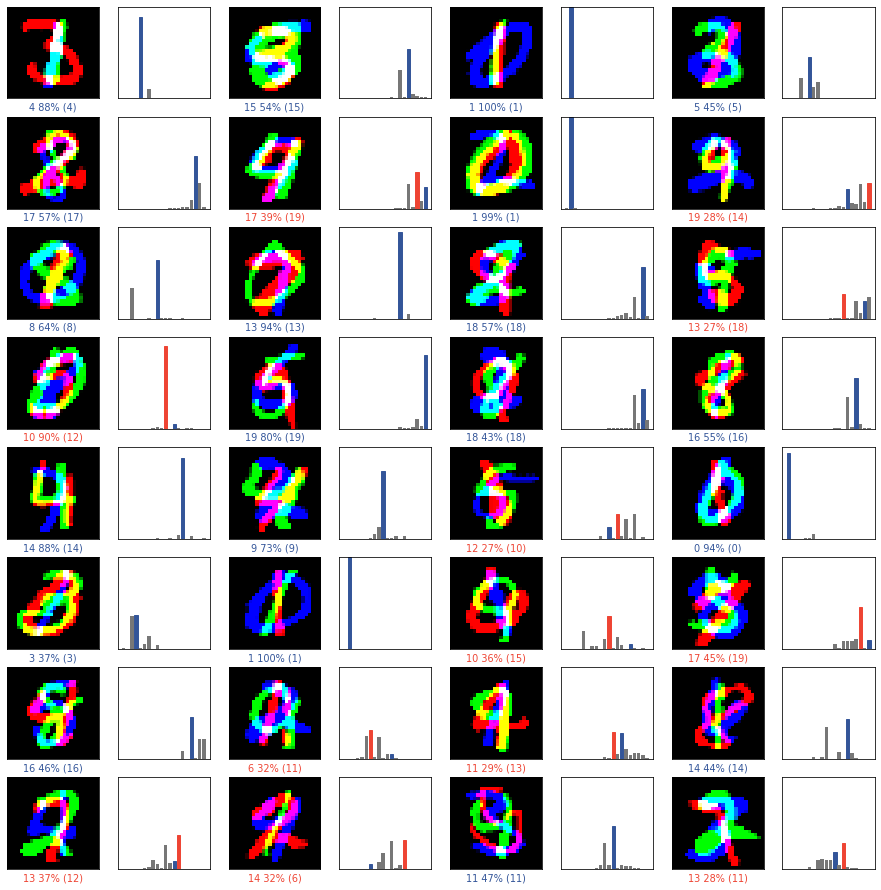

In [71]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = np.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())